# Overlaying speed traces of two laps

Compare two fastest laps by overlaying their speed traces.


In [1]:
%pip install fastf1
%pip install seaborn
%matplotlib inline


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt

import fastf1.plotting

import pandas as pd

from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML

import seaborn as sns

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

from matplotlib import gridspec

from matplotlib.collections import LineCollection

import os

/Users/enrique/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [31]:


# enable some matplotlib patches for plotting timedelta values and load
# FastF1's default color scheme
fastf1.plotting.setup_mpl(misc_mpl_mods=False)

# load a session and its telemetry data
grand_prix_session = 'FP2'
grand_prix_year = 2024
grand_prix_weekend = 4
session = fastf1.get_session(grand_prix_year, grand_prix_weekend, grand_prix_session)
grand_prix_name = session.event['EventName']
grand_prix_name_official = session.event['OfficialEventName']
session.load()

core           INFO 	Loading data for Japanese Grand Prix - Practice 2 [v3.3.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 1
core        

First, we select the two laps that we want to compare



In [113]:
ver_lap = session.laps.pick_driver('VER').pick_fastest()
per_lap = session.laps.pick_driver('PER').pick_fastest()
sai_lap = session.laps.pick_driver('SAI').pick_fastest()
lec_lap = session.laps.pick_driver('LEC').pick_fastest()
#bea_lap = session.laps.pick_driver('BEA').pick_fastest()
alo_lap = session.laps.pick_driver('ALO').pick_fastest()
str_lap = session.laps.pick_driver('STR').pick_fastest()
ham_lap = session.laps.pick_driver('HAM').pick_fastest()
rus_lap = session.laps.pick_driver('RUS').pick_fastest()

Next we get the telemetry data for each lap. We also add a 'Distance' column
to the telemetry dataframe as this makes it easier to compare the laps.



In [114]:
ver_tel = ver_lap.get_car_data().add_distance()
per_tel = per_lap.get_car_data().add_distance()
sai_tel = sai_lap.get_car_data().add_distance()
lec_tel = lec_lap.get_car_data().add_distance()
#bea_tel = bea_lap.get_car_data().add_distance()
alo_tel = alo_lap.get_car_data().add_distance()
str_tel = str_lap.get_car_data().add_distance()
ham_tel = ham_lap.get_car_data().add_distance()
rus_tel = rus_lap.get_car_data().add_distance()

In [4]:
def name_to_color_hex(name):
    """Convierte un nombre en un color hexadecimal."""
    
    # Diccionario de colores predefinidos para ciertos pilotos
    default_colors = {
        'ALO': '#009F60',  # Verde Aston Martin para Alonso.
        'STR': '#007F50',  # Un verde ligeramente diferente para Stroll, pero aún en la gama de Aston Martin.
        'HAM': '#00D2BE',  # Turquesa, ya definido para Mercedes.
        'RUS': '#5E5E5E',  # Gris, para diferenciarlo de Hamilton pero aún asociado con Mercedes.
        'VER': '#0600EF',  # Azul, ya definido.
        'PER': '#f400FF',  # Un azul diferente a Verstappen, pero cercano para reflejar Red Bull Racing.
        'SAI': '#DC0000',  # Rojo, colores de Ferrari.
        'LEC': '#FFD700',  # Amarillo para Leclerc, como pediste.
        'BEA': '#F596C8',  # Rosa, imaginando un color distintivo que no choque con otros.
        'RIC': '#FF8700',  # Naranja, asociado con McLaren.
        'TSU': '#2B4562',  # Azul oscuro, pensando en AlphaTauri.
        'PIA': '#FFA500',  # Un naranja diferente para Piastri, compañero de equipo en McLaren.
        'LAN': '#FF5733'  # Ya definido, pero ahora representa McLaren junto con Piastri.
    }
    
    # Verifica si el nombre está en el diccionario de colores predefinidos
    if name in default_colors:
        return default_colors[name]
    else:
        # Si no está predefinido, genera un color nuevo
        hash_value = abs(hash(name))
        color_hex = f'#{hash_value:06X}'[-6:]
        color_hex_full = f"#{color_hex}"
        return color_hex_full

In [5]:
def format_lap_time(timedelta):
    """
    Formatea un objeto Timedelta a una cadena en el formato MM:SS.sss.
    
    :param timedelta: Timedelta, el tiempo de vuelta a formatear.
    :return: str, el tiempo formateado como MM:SS.sss.
    """
    total_seconds = timedelta.total_seconds()
    minutes = int(total_seconds // 60)
    seconds = total_seconds % 60
    formatted_time = f"{minutes:02d}:{seconds:06.3f}"
    return formatted_time

In [6]:
def format_lap_time_full(timedelta):
    """
    Formatea un objeto Timedelta a una cadena en el formato MM:SS.sss.
    
    :param timedelta: Timedelta, el tiempo de vuelta a formatear.
    :return: str, el tiempo formateado como MM:SS.sss.
    """
    total_seconds = timedelta.total_seconds()
    minutes = int(total_seconds // 60)
    seconds = total_seconds % 60
    formatted_time = f"{minutes:02d}:{seconds:06.3f}"
    return formatted_time

In [7]:
def calculate_sector_time_diff(telemetry, driver1, driver2):
    sector_time_diff = telemetry.loc[telemetry['Driver'] == driver1, 'Sector_time'] - \
                       telemetry.loc[telemetry['Driver'] == driver2, 'Sector_time']
    return sector_time_diff

Finally, we create a plot and plot both speed traces.
We color the individual lines with the driver's team colors.



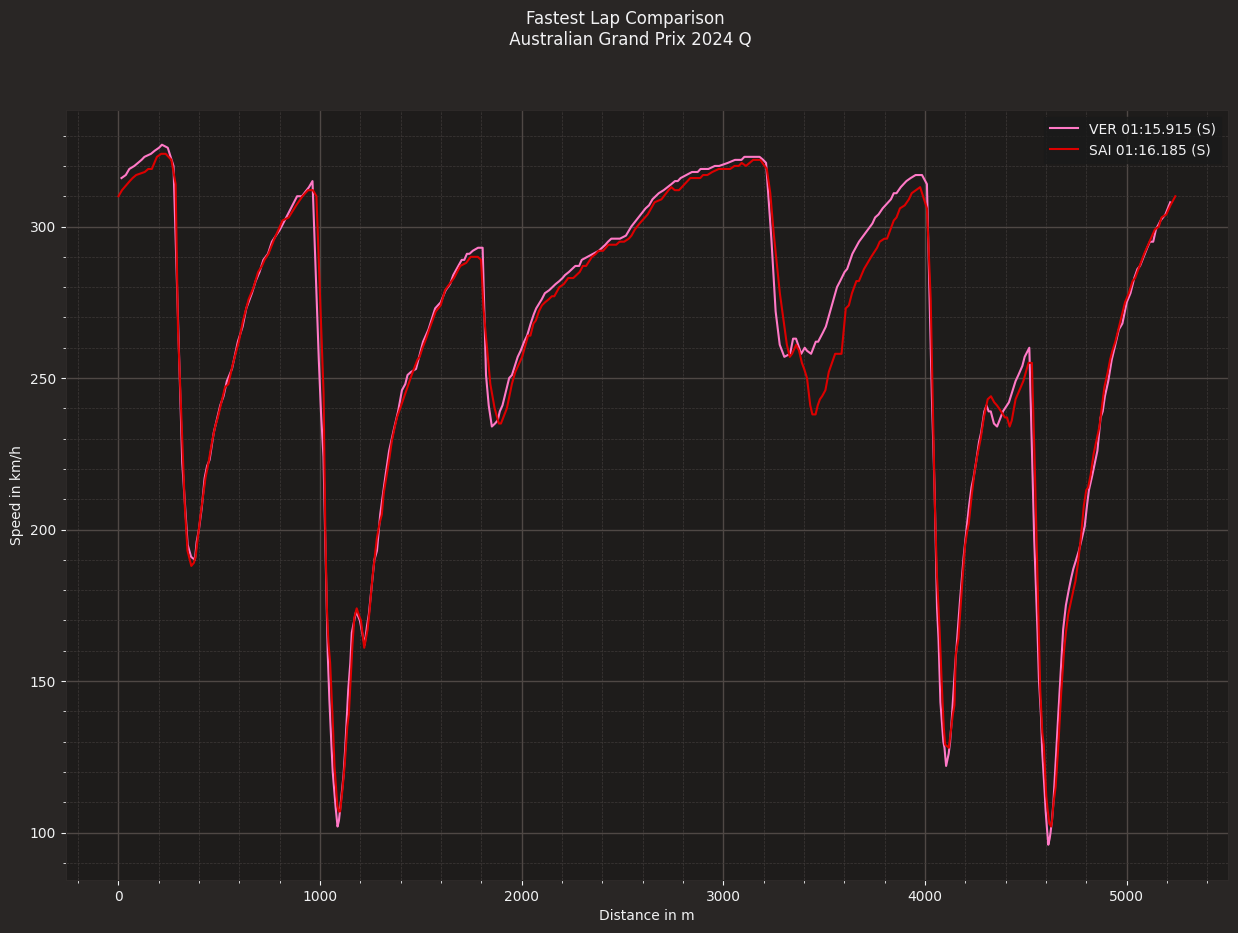

In [115]:
rbr_color = fastf1.plotting.team_color('RBR')
mer_color = fastf1.plotting.team_color('MER')
ast_color = fastf1.plotting.team_color('AST')
fer_color = fastf1.plotting.team_color('FER')
mcl_color = fastf1.plotting.team_color('MCL')

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(ver_tel['Distance'], ver_tel['Speed'], label=f"VER {format_lap_time(ver_lap['LapTime'])} ({ver_lap['Compound'][0]})")
#ax.plot(per_tel['Distance'], per_tel['Speed'], label=f"PER {format_lap_time(per_lap['LapTime'])} ({per_lap['Compound'][0]})")
#ax.plot(ver_tel['Distance'], lec_tel['Speed'], label=f"LEC {format_lap_time(lec_lap['LapTime'])} ({lec_lap['Compound'][0]})")
#ax.plot(per_tel['Distance'], bea_tel['Speed'], label=f"BEA {format_lap_time(bea_lap['LapTime'])} ({bea_lap['Compound'][0]})")
ax.plot(sai_tel['Distance'], sai_tel['Speed'], color=fer_color, label=f"SAI {format_lap_time(sai_lap['LapTime'])} ({sai_lap['Compound'][0]})")
#ax.plot(alo_tel['Distance'], alo_tel['Speed'], color=ast_color, label=f"ALO {format_lap_time(alo_lap['LapTime'])} ({alo_lap['Compound'][0]})")
#ax.plot(str_tel['Distance'], str_tel['Speed'], label=f"STR {format_lap_time(str_lap['LapTime'])} ({str_lap['Compound'][0]})")
#ax.plot(ham_tel['Distance'], ham_tel['Speed'], color=mer_color, label=f"HAM {format_lap_time(ham_lap['LapTime'])} ({ham_lap['Compound'][0]})")
#ax.plot(rus_tel['Distance'], rus_tel['Speed'], color=mer_color, label=f"RUS {format_lap_time(rus_lap['LapTime'])} ({rus_lap['Compound'][0]})")

ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed in km/h')

ax.legend()
plt.suptitle(f"Fastest Lap Comparison \n "
             f"{grand_prix_name} {session.event.year} {grand_prix_session}")

plt.show()

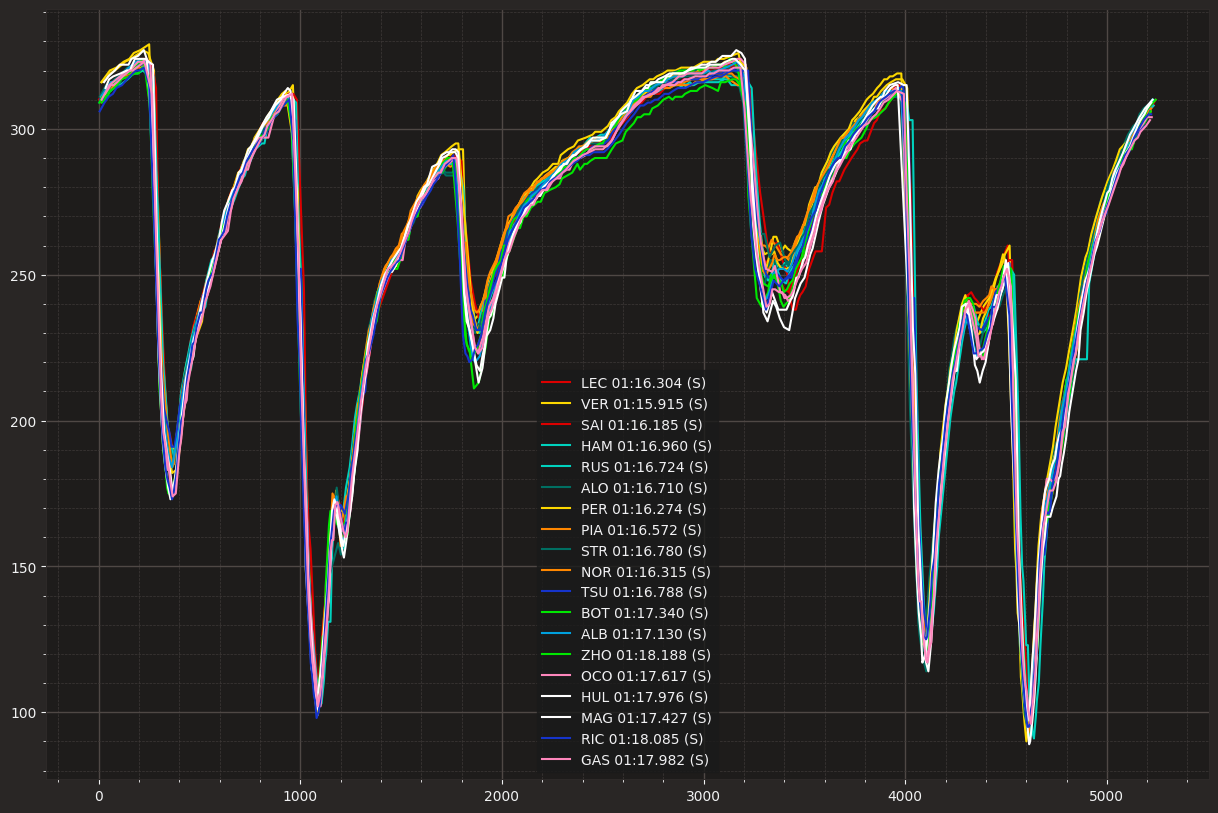

In [31]:
# Obtén una lista única de corredores desde la sesión
corredores = session.laps['Driver'].unique()

# Prepara la figura de matplotlib
#fig, ax = plt.subplots()
# Prepara la figura de matplotlib con un tamaño mayor
fig, ax = plt.subplots(figsize=(15, 10))  # Ajusta estos valores para cambiar el tamaño


# Itera sobre cada corredor para obtener su vuelta más rápida y graficarla
for corredor in corredores:
    # Selecciona la vuelta más rápida
    vuelta_rapida = session.laps.pick_driver(corredor).pick_fastest()
    
    # Extrae los datos del coche y agrega la distancia
    datos_coche = vuelta_rapida.get_car_data().add_distance()
    
    # Determina el equipo del corredor (si la información está disponible)
    equipo = vuelta_rapida['Team']
    
    # Obtiene el color asociado al equipo del corredor
    color_equipo = fastf1.plotting.team_color(equipo)
    
    # Formatea el tiempo de vuelta para la etiqueta
    tiempo_vuelta = format_lap_time(vuelta_rapida['LapTime'])
    
    # Añade la traza al gráfico
    ax.plot(datos_coche['Distance'], datos_coche['Speed'], color=color_equipo, 
            label=f"{corredor} {tiempo_vuelta} ({vuelta_rapida['Compound'][0]})")

# Ajusta detalles finales del gráfico
ax.legend()
plt.show()

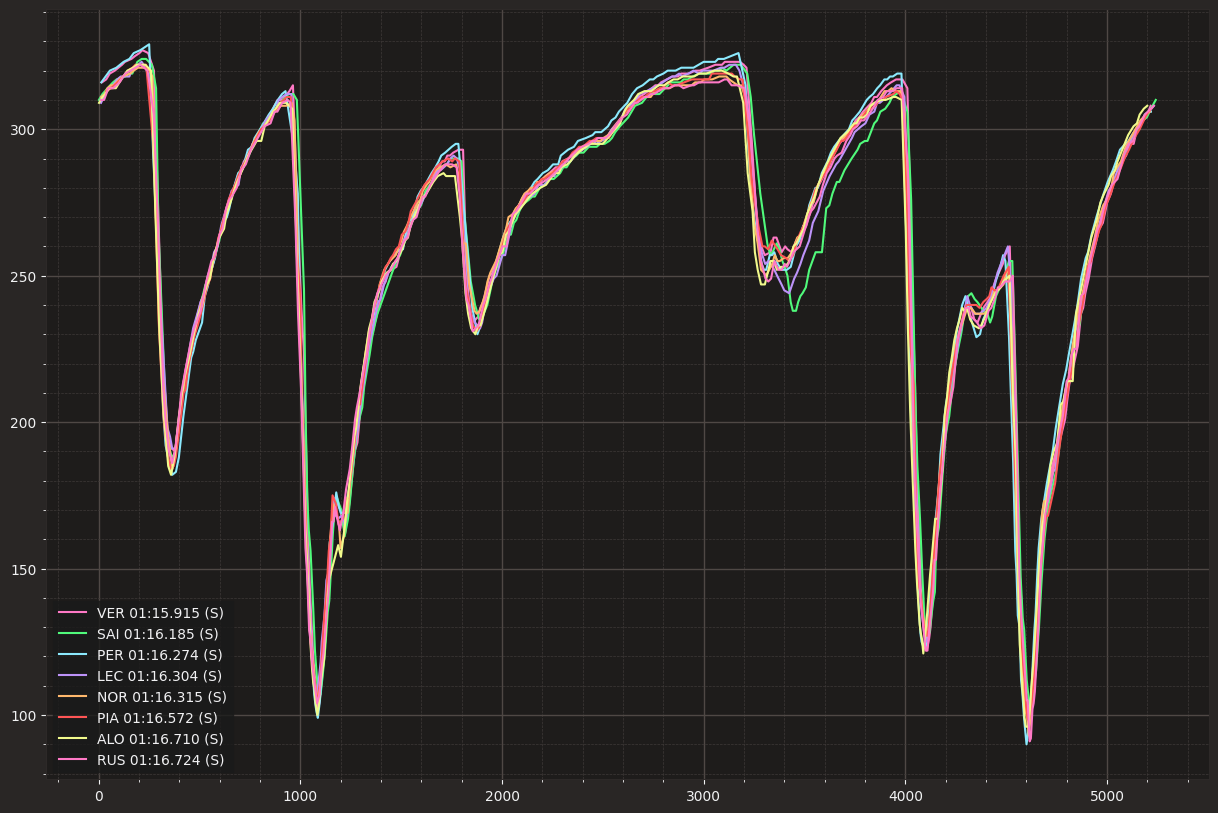

In [32]:

fastf1.plotting.setup_mpl()

# Asumiendo que 'session' ya contiene los datos de la sesión de interés cargados
# Obtén todas las vueltas más rápidas de todos los corredores
vueltas_rapidas = [session.laps.pick_driver(corredor).pick_fastest() for corredor in session.laps['Driver'].unique()]

# Filtra las vueltas para asegurar que todas tienen un tiempo registrado
vueltas_rapidas = [vuelta for vuelta in vueltas_rapidas if vuelta['LapTime'] is not None]

# Ordena las vueltas por tiempo de vuelta
vueltas_rapidas.sort(key=lambda x: x['LapTime'])

# Selecciona las 10 vueltas más rápidas
diez_vueltas_mas_rapidas = vueltas_rapidas[:8]

# Prepara la figura de matplotlib con un tamaño mayor
fig, ax = plt.subplots(figsize=(15, 10))

# Grafica cada una de las 10 vueltas más rápidas
for vuelta in diez_vueltas_mas_rapidas:
    datos_coche = vuelta.get_car_data().add_distance()
    equipo = vuelta['Team']
    color_equipo = fastf1.plotting.team_color(equipo)
    corredor = vuelta['Driver']
    #tiempo_vuelta = vuelta['LapTime'].total_seconds()  # Modifica aquí según cómo desees formatear el tiempo
    tiempo_vuelta = format_lap_time(vuelta['LapTime'])
    
    ax.plot(datos_coche['Distance'], datos_coche['Speed'], 
            label=f"{corredor} {tiempo_vuelta} ({vuelta_rapida['Compound'][0]})")

# Añade leyendas y ajustes finales al gráfico
ax.legend()
plt.show()

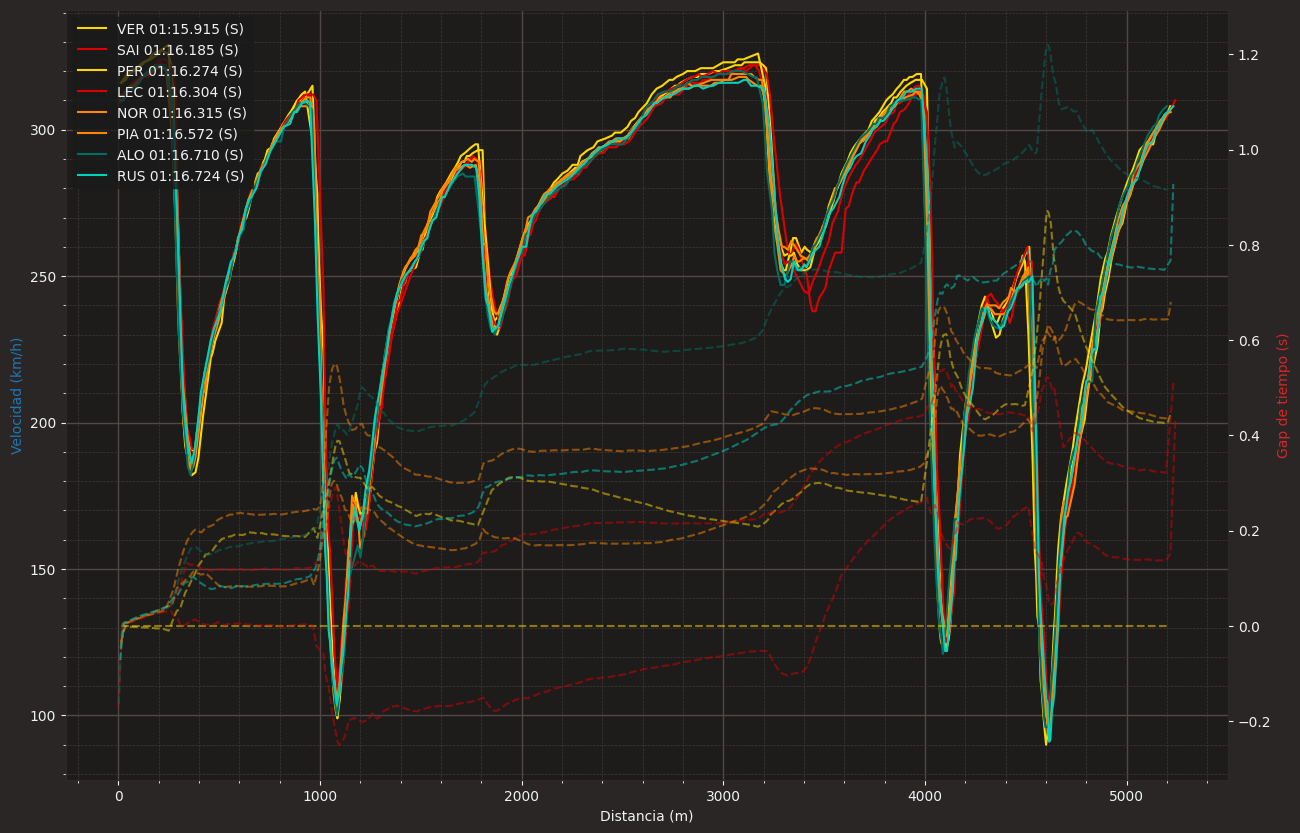

In [33]:
fastf1.plotting.setup_mpl()

# Preparación inicial igual...
vueltas_rapidas = [session.laps.pick_driver(corredor).pick_fastest() for corredor in session.laps['Driver'].unique()]
vueltas_rapidas = [vuelta for vuelta in vueltas_rapidas if vuelta['LapTime'] is not None]
vueltas_rapidas.sort(key=lambda x: x['LapTime'])
diez_vueltas_mas_rapidas = vueltas_rapidas[:8]

# Vuelta de referencia (la mejor vuelta)
vuelta_referencia = vueltas_rapidas[0]
datos_coche_ref = vuelta_referencia.get_car_data().add_distance()
tiempo_ref = datos_coche_ref['Time'].dt.total_seconds()

fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()  # Segundo eje para el gap de tiempo

for vuelta in diez_vueltas_mas_rapidas:
    datos_coche = vuelta.get_car_data().add_distance()
    equipo = vuelta['Team']
    color_equipo = fastf1.plotting.team_color(equipo)
    corredor = vuelta['Driver']
    tiempo_vuelta = format_lap_time(vuelta['LapTime'])

    # Graficar la velocidad en el primer eje
    ax1.plot(datos_coche['Distance'], datos_coche['Speed'], label=f"{corredor} {tiempo_vuelta} ({vuelta['Compound'][0]})", color=color_equipo)

    # Calcular y graficar el gap de tiempo en el segundo eje
    tiempo_vuelta_sec = datos_coche['Time'].dt.total_seconds()
    distancia = datos_coche['Distance']
    tiempo_ref_interp = np.interp(distancia, datos_coche_ref['Distance'], tiempo_ref)
    gap_tiempo = tiempo_vuelta_sec - tiempo_ref_interp
    
    # Para evitar superposición de etiquetas, podemos no añadir una leyenda aquí, o usar un esquema de color/nombres diferenciado
    ax2.plot(distancia, gap_tiempo, linestyle='--', color=color_equipo, alpha=0.5)  # alpha para diferenciar la línea de gap

# Configuración de los ejes
ax1.set_xlabel('Distancia (m)')
ax1.set_ylabel('Velocidad (km/h)', color='tab:blue')
ax2.set_ylabel('Gap de tiempo (s)', color='tab:red')
ax1.legend(loc='upper left')

plt.show()

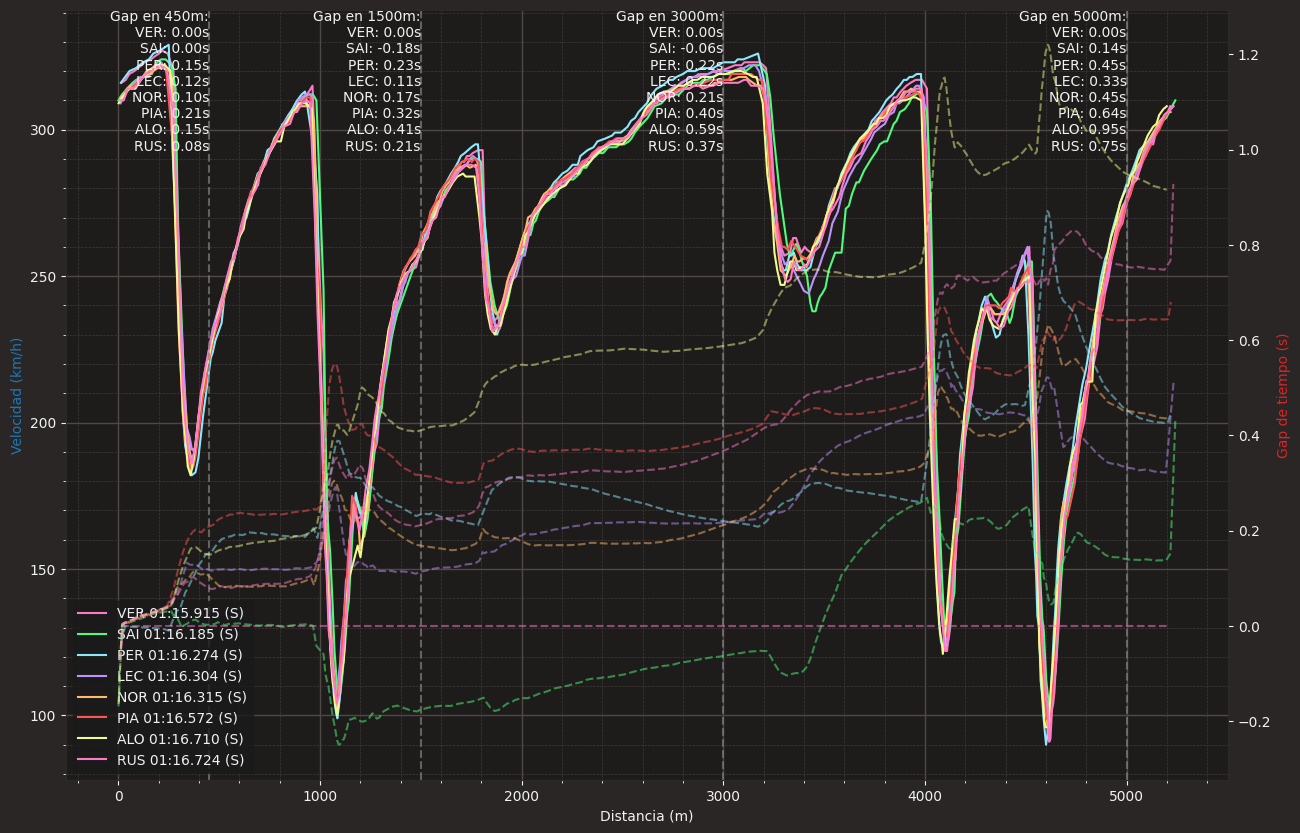

In [34]:
fastf1.plotting.setup_mpl()

# Preparación inicial igual...
vueltas_rapidas = [session.laps.pick_driver(corredor).pick_fastest() for corredor in session.laps['Driver'].unique()]
vueltas_rapidas = [vuelta for vuelta in vueltas_rapidas if vuelta['LapTime'] is not None]
vueltas_rapidas.sort(key=lambda x: x['LapTime'])
diez_vueltas_mas_rapidas = vueltas_rapidas[:8]

# Vuelta de referencia (la mejor vuelta)
vuelta_referencia = vueltas_rapidas[0]
datos_coche_ref = vuelta_referencia.get_car_data().add_distance()
tiempo_ref = datos_coche_ref['Time'].dt.total_seconds()

fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()  # Segundo eje para el gap de tiempo

# Distancias específicas para mostrar el gap de tiempo
distancias_puntos = [450, 1500, 3000, 5000]

# Inicializar diccionario para almacenar los gaps en puntos específicos
gaps_en_puntos = {distancia: [] for distancia in distancias_puntos}

for vuelta in diez_vueltas_mas_rapidas:
    datos_coche = vuelta.get_car_data().add_distance()
    equipo = vuelta['Team']
    color_equipo = fastf1.plotting.team_color(equipo)
    corredor = vuelta['Driver']
    tiempo_vuelta = format_lap_time(vuelta['LapTime'])

    ax1.plot(datos_coche['Distance'], datos_coche['Speed'], label=f"{corredor} {tiempo_vuelta} ({vuelta['Compound'][0]})")

    # Cálculo de gap de tiempo
    tiempo_vuelta_sec = datos_coche['Time'].dt.total_seconds()
    distancia = datos_coche['Distance']
    tiempo_ref_interp = np.interp(distancia, datos_coche_ref['Distance'], tiempo_ref)
    gap_tiempo = tiempo_vuelta_sec - tiempo_ref_interp
    ax2.plot(distancia, gap_tiempo, linestyle='--', alpha=0.5)

    # Calcular y almacenar el gap de tiempo en puntos específicos de distancia
    for punto in distancias_puntos:
        gap_en_punto = np.interp(punto, distancia, gap_tiempo)
        gaps_en_puntos[punto].append((corredor, gap_en_punto))

# Añadir líneas verticales y anotaciones para los puntos específicos
for punto in distancias_puntos:
    # Línea vertical en cada punto específico
    ax1.axvline(x=punto, color='grey', linestyle='--', alpha=0.7)

    # Anotar los gaps de tiempo en los puntos específicos
    texto_anotacion = f"Gap en {punto}m:\n" + "\n".join([f"{corredor}: {gap:.2f}s" for corredor, gap in gaps_en_puntos[punto]])
    ax1.text(punto, ax1.get_ylim()[1], texto_anotacion, verticalalignment='top', horizontalalignment='right')

# Configuración de los ejes
ax1.set_xlabel('Distancia (m)')
ax1.set_ylabel('Velocidad (km/h)', color='tab:blue')
ax2.set_ylabel('Gap de tiempo (s)', color='tab:red')
ax1.legend()

plt.show()

In [35]:
#####

MUESTRA GRAFICA

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x105d71f70>>
Traceback (most recent call last):
  File "/Users/enrique.mendoza/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


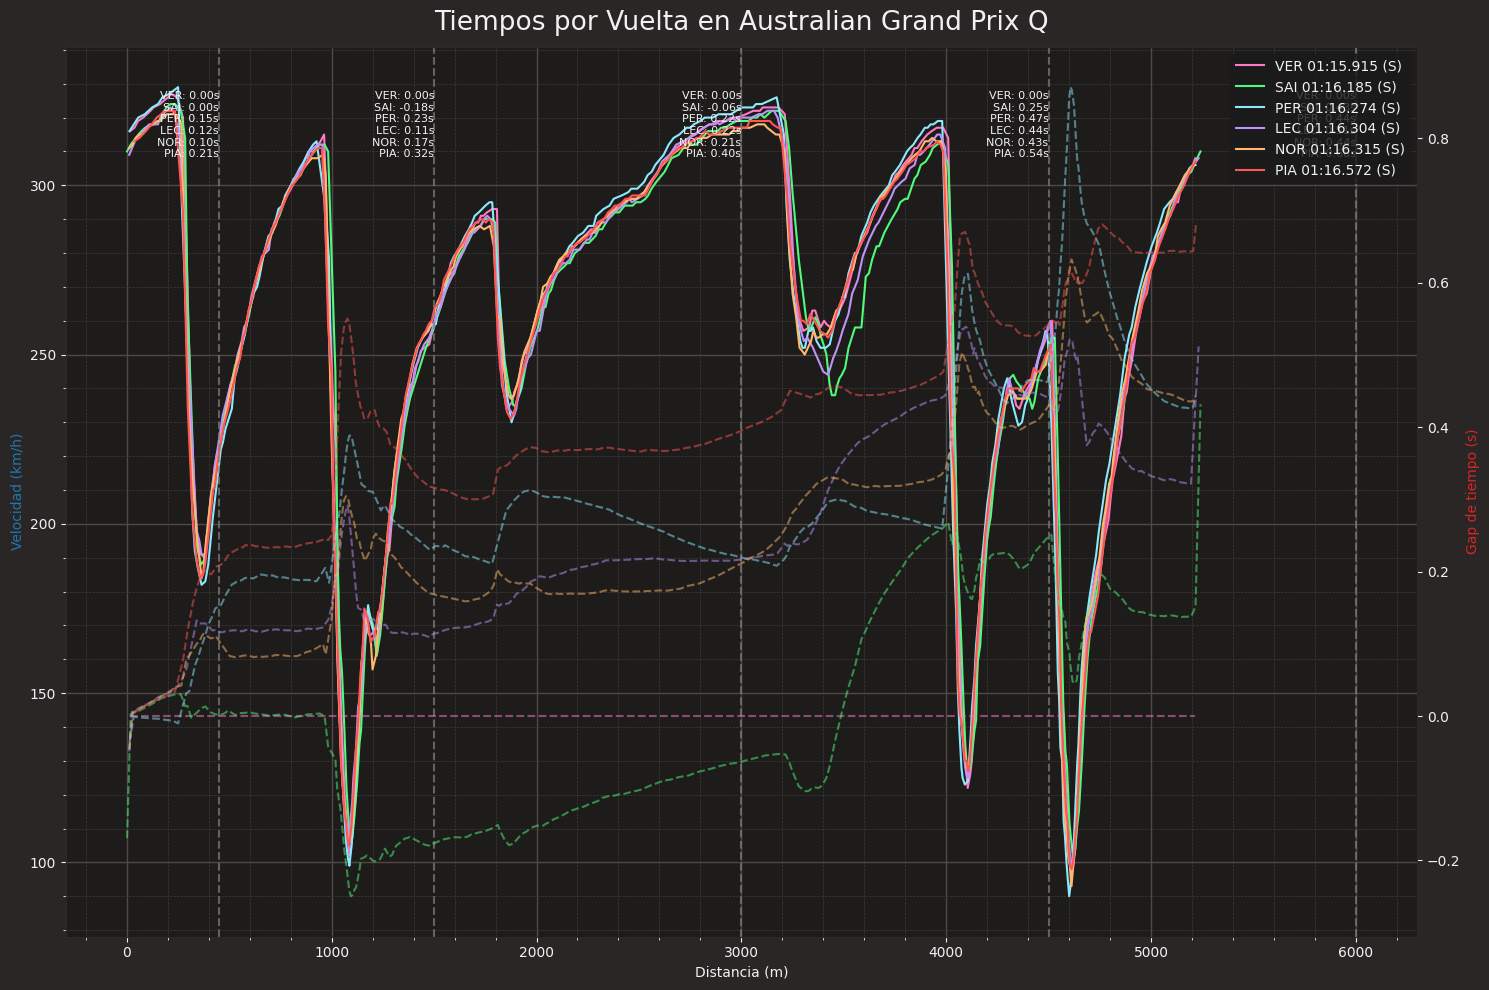

In [112]:
fastf1.plotting.setup_mpl()

vueltas_rapidas = [session.laps.pick_driver(corredor).pick_fastest() for corredor in session.laps['Driver'].unique()]
vueltas_rapidas = [vuelta for vuelta in vueltas_rapidas if pd.notna(vuelta['LapTime'])]

# Si LapTime ya está en segundos (o convertido a float), ordena directamente
vueltas_rapidas.sort(key=lambda x: x['LapTime'])

diez_vueltas_mas_rapidas = vueltas_rapidas[:6]

# Identificación de la vuelta de referencia (la mejor vuelta) y obtención de su telemetría
vuelta_referencia = vueltas_rapidas[0]
datos_coche_ref = vuelta_referencia.get_car_data().add_distance()
tiempo_ref = datos_coche_ref['Time'].dt.total_seconds()

# Preparación del gráfico con un tamaño mayor
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()  # Creación de un segundo eje para el gap de tiempo

# Definición de las distancias específicas para mostrar el gap de tiempo
distancias_puntos = [450, 1500, 3000, 4500, 6000]

# Inicialización de un diccionario para almacenar los gaps en puntos específicos
gaps_en_puntos = {distancia: [] for distancia in distancias_puntos}

# Procesamiento y gráfica de cada una de las vueltas seleccionadas
for vuelta in diez_vueltas_mas_rapidas:
    datos_coche = vuelta.get_car_data().add_distance()
    equipo = vuelta['Team']
    #color_equipo = fastf1.plotting.team_color(equipo)
    corredor = vuelta['Driver']
    tiempo_vuelta = format_lap_time(vuelta['LapTime'])  # Asegúrate de tener esta función definida
    
    # Gráfica de la velocidad en el primer eje y
    ax1.plot(datos_coche['Distance'], datos_coche['Speed'], label=f"{corredor} {tiempo_vuelta} ({vuelta['Compound'][0]})")
    
    # Cálculo y gráfica del gap de tiempo en el segundo eje y
    tiempo_vuelta_sec = datos_coche['Time'].dt.total_seconds()
    distancia = datos_coche['Distance']
    tiempo_ref_interp = np.interp(distancia, datos_coche_ref['Distance'], tiempo_ref)
    gap_tiempo = tiempo_vuelta_sec - tiempo_ref_interp
    ax2.plot(distancia, gap_tiempo, linestyle='--', alpha=0.5)

    # Cálculo del gap de tiempo en puntos específicos de distancia y almacenamiento para anotaciones posteriores
    for punto in distancias_puntos:
        gap_en_punto = np.interp(punto, distancia, gap_tiempo)
        gaps_en_puntos[punto].append(f"{corredor}: {gap_en_punto:.2f}s")

# Añadir líneas verticales y anotaciones de gap de tiempo en puntos específicos
for punto in distancias_puntos:
    ax1.axvline(x=punto, color='grey', linestyle='--', alpha=0.7)
    
    # Calcular el ajuste para bajar la anotación
    rango_y = ax1.get_ylim()[1] - ax1.get_ylim()[0]  # Diferencia entre el valor máximo y mínimo del eje y
    ajuste = rango_y * 0.05  # Ajuste del 5% del rango del eje y, modifica este valor según necesidad
    
    # Actualiza la posición de la anotación para moverla un poco más abajo
    texto_anotacion = "\n".join(gaps_en_puntos[punto])
    ax1.text(punto, ax1.get_ylim()[1] - ajuste, texto_anotacion, verticalalignment='top', horizontalalignment='right', fontsize=8)

# Configuración de los ejes y visualización final
ax1.set_xlabel('Distancia (m)')
ax1.set_ylabel('Velocidad (km/h)', color='tab:blue')
ax2.set_ylabel('Gap de tiempo (s)', color='tab:red')
ax1.legend()
plt.title(f'Tiempos por Vuelta en {grand_prix_name} {grand_prix_session}')
plt.tight_layout()
plt.show()

EXPORTA DATOS Y CREA GRAFICA

/Users/enrique/Library/Python/3.9/lib/python/site-packages/fastf1/core.py:3063: FutureWarning: In the future, `None` will be returned instead of an empty `Lap` object when there are no laps that satisfy the definition for fastest lap.
  warnings.warn(("In the future, `None` will be returned instead of "


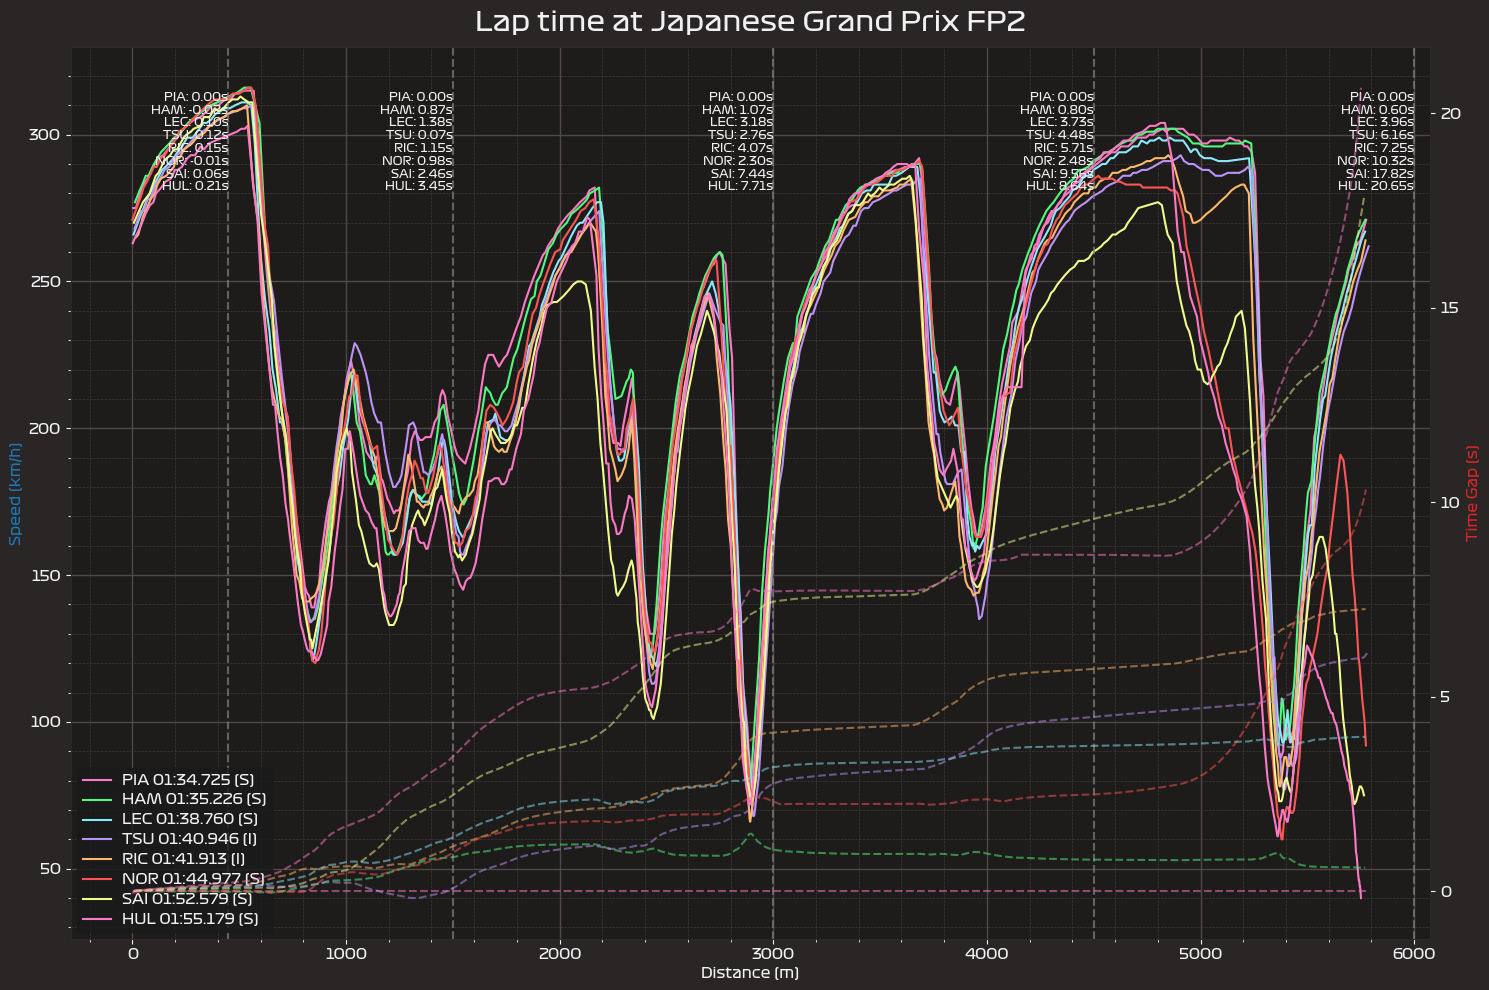

In [32]:
fastf1.plotting.setup_mpl()

vueltas_rapidas = [session.laps.pick_driver(corredor).pick_fastest() for corredor in session.laps['Driver'].unique()]
vueltas_rapidas = [vuelta for vuelta in vueltas_rapidas if pd.notna(vuelta['LapTime'])]

# Si LapTime ya está en segundos (o convertido a float), ordena directamente
vueltas_rapidas.sort(key=lambda x: x['LapTime'])

diez_vueltas_mas_rapidas = vueltas_rapidas[:8]

# Identificación de la vuelta de referencia (la mejor vuelta) y obtención de su telemetría
vuelta_referencia = vueltas_rapidas[0]
datos_coche_ref = vuelta_referencia.get_car_data().add_distance()
tiempo_ref = datos_coche_ref['Time'].dt.total_seconds()

# Preparación del gráfico con un tamaño mayor
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()  # Creación de un segundo eje para el gap de tiempo

# Definición de las distancias específicas para mostrar el gap de tiempo
distancias_puntos = [450, 1500, 3000, 4500, 6000]

# Inicialización de un diccionario para almacenar los gaps en puntos específicos
gaps_en_puntos = {distancia: [] for distancia in distancias_puntos}

# Lista para almacenar los datos antes de crear el DataFrame
datos_list = []

# Procesamiento y gráfica de cada una de las vueltas seleccionadas
for vuelta in diez_vueltas_mas_rapidas:
    datos_coche = vuelta.get_car_data().add_distance()
    equipo = vuelta['Team']
    #color_equipo = fastf1.plotting.team_color(equipo)
    corredor = vuelta['Driver']
    tiempo_vuelta = format_lap_time(vuelta['LapTime'])  # Asegúrate de tener esta función definida
    
    # Gráfica de la velocidad en el primer eje y
    ax1.plot(datos_coche['Distance'], datos_coche['Speed'], label=f"{corredor} {tiempo_vuelta} ({vuelta['Compound'][0]})")
    
    # Cálculo y gráfica del gap de tiempo en el segundo eje y
    tiempo_vuelta_sec = datos_coche['Time'].dt.total_seconds()
    distancia = datos_coche['Distance']
    tiempo_ref_interp = np.interp(distancia, datos_coche_ref['Distance'], tiempo_ref)
    gap_tiempo = tiempo_vuelta_sec - tiempo_ref_interp
    ax2.plot(distancia, gap_tiempo, linestyle='--', alpha=0.5)

    # Compilar datos para cada punto de distancia
    for d, s, g in zip(distancia, datos_coche['Speed'], gap_tiempo):
        datos_list.append({
            'Driver': corredor, 
            'LapTime': tiempo_vuelta, 
            'Distance': d, 
            'Speed': s, 
            'GapTime': g
        })

    # Cálculo del gap de tiempo en puntos específicos de distancia y almacenamiento para anotaciones posteriores
    for punto in distancias_puntos:
        gap_en_punto = np.interp(punto, distancia, gap_tiempo)
        gaps_en_puntos[punto].append(f"{corredor}: {gap_en_punto:.2f}s")

# Añadir líneas verticales y anotaciones de gap de tiempo en puntos específicos
for punto in distancias_puntos:
    ax1.axvline(x=punto, color='grey', linestyle='--', alpha=0.7)
    
    # Calcular el ajuste para bajar la anotación
    rango_y = ax1.get_ylim()[1] - ax1.get_ylim()[0]  # Diferencia entre el valor máximo y mínimo del eje y
    ajuste = rango_y * 0.05  # Ajuste del 5% del rango del eje y, modifica este valor según necesidad
    
    # Actualiza la posición de la anotación para moverla un poco más abajo
    texto_anotacion = "\n".join(gaps_en_puntos[punto])
    ax1.text(punto, ax1.get_ylim()[1] - ajuste, texto_anotacion, verticalalignment='top', horizontalalignment='right', fontsize=8)

# Configuración de los ejes y visualización final
ax1.set_xlabel('Distance (m)')
ax1.set_ylabel('Speed (km/h)', color='tab:blue')
ax2.set_ylabel('Time Gap (s)', color='tab:red')
ax1.legend()
plt.title(f'Lap time at {grand_prix_name} {grand_prix_session}')
plt.tight_layout()
plt.show()

# Crear el DataFrame de pandas a partir de la lista de datos
datos_para_exportar = pd.DataFrame(datos_list)

# Exportar el DataFrame a un archivo CSV
ruta_archivo = 'datos_vueltas_rapidas.csv'
datos_para_exportar.to_csv(ruta_archivo, index=False)

TIEMPOS DE VUELTA MEDIO PRA EL TOP 8

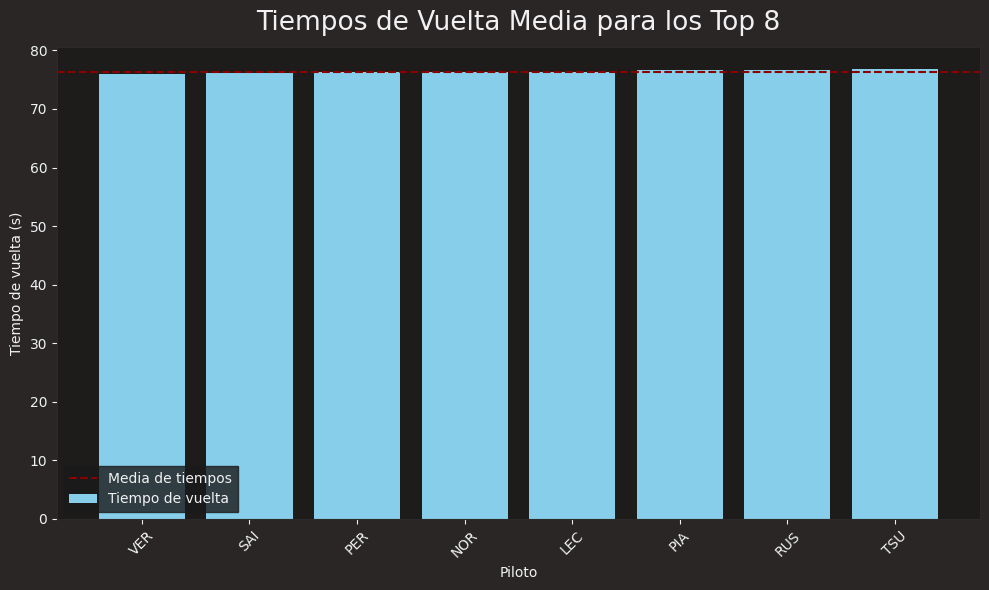

In [38]:


# Obtener los resultados finales y convertirlos a un DataFrame de pandas
results = session.results
# Asegúrate de que 'TotalTime' está en un formato que permita la comparación, como timedelta si no lo está ya
results['Time'] = pd.to_timedelta(results['Time'])

# Ordena los resultados por 'TotalTime'
results_sorted = results.sort_values(by='Time')

# Selecciona los primeros 8 registros después de ordenar
top8 = results_sorted.head(8)

# Obtener las vueltas rápidas de los pilotos que terminaron en el top 8
vueltas_rapidas_top8 = [session.laps.pick_driver(row['Abbreviation']).pick_fastest() for index, row in top8.iterrows()]
vueltas_rapidas_top8 = [vuelta for vuelta in vueltas_rapidas_top8 if pd.notna(vuelta['LapTime'])]

# Calcula la media de los tiempos de vuelta (en segundos)
tiempos_vuelta = [vuelta['LapTime'].total_seconds() for vuelta in vueltas_rapidas_top8]
media_tiempos = np.mean(tiempos_vuelta)

# Preparación del gráfico
plt.figure(figsize=(10, 6))
plt.bar(range(len(vueltas_rapidas_top8)), tiempos_vuelta, color='skyblue', label='Tiempo de vuelta')
plt.axhline(y=media_tiempos, color='darkred', linestyle='--', label='Media de tiempos')
plt.xticks(range(len(vueltas_rapidas_top8)), [vuelta['Driver'] for vuelta in vueltas_rapidas_top8], rotation=45)
plt.ylabel('Tiempo de vuelta (s)')
plt.xlabel('Piloto')
plt.title(f'Tiempos de Vuelta Media para los Top 8')
plt.legend()
plt.tight_layout()
plt.show()


TEAM COMPARISON

In [12]:
laps = session.laps.pick_quicklaps()
transformed_laps = laps.copy()
transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()

# order the team from the fastest (lowest median lap time) tp slower
team_order = (
    transformed_laps[["Team", "LapTime (s)"]]
    .groupby("Team")
    .median()["LapTime (s)"]
    .sort_values()
    .index
)
print(team_order)

# make a color palette associating team names to hex codes
team_palette = {team: fastf1.plotting.team_color(team) for team in team_order}

Index(['Red Bull Racing', 'Aston Martin', 'Kick Sauber', 'Williams',
       'Mercedes', 'Alpine', 'RB', 'McLaren', 'Haas F1 Team', 'Ferrari'],
      dtype='object', name='Team')


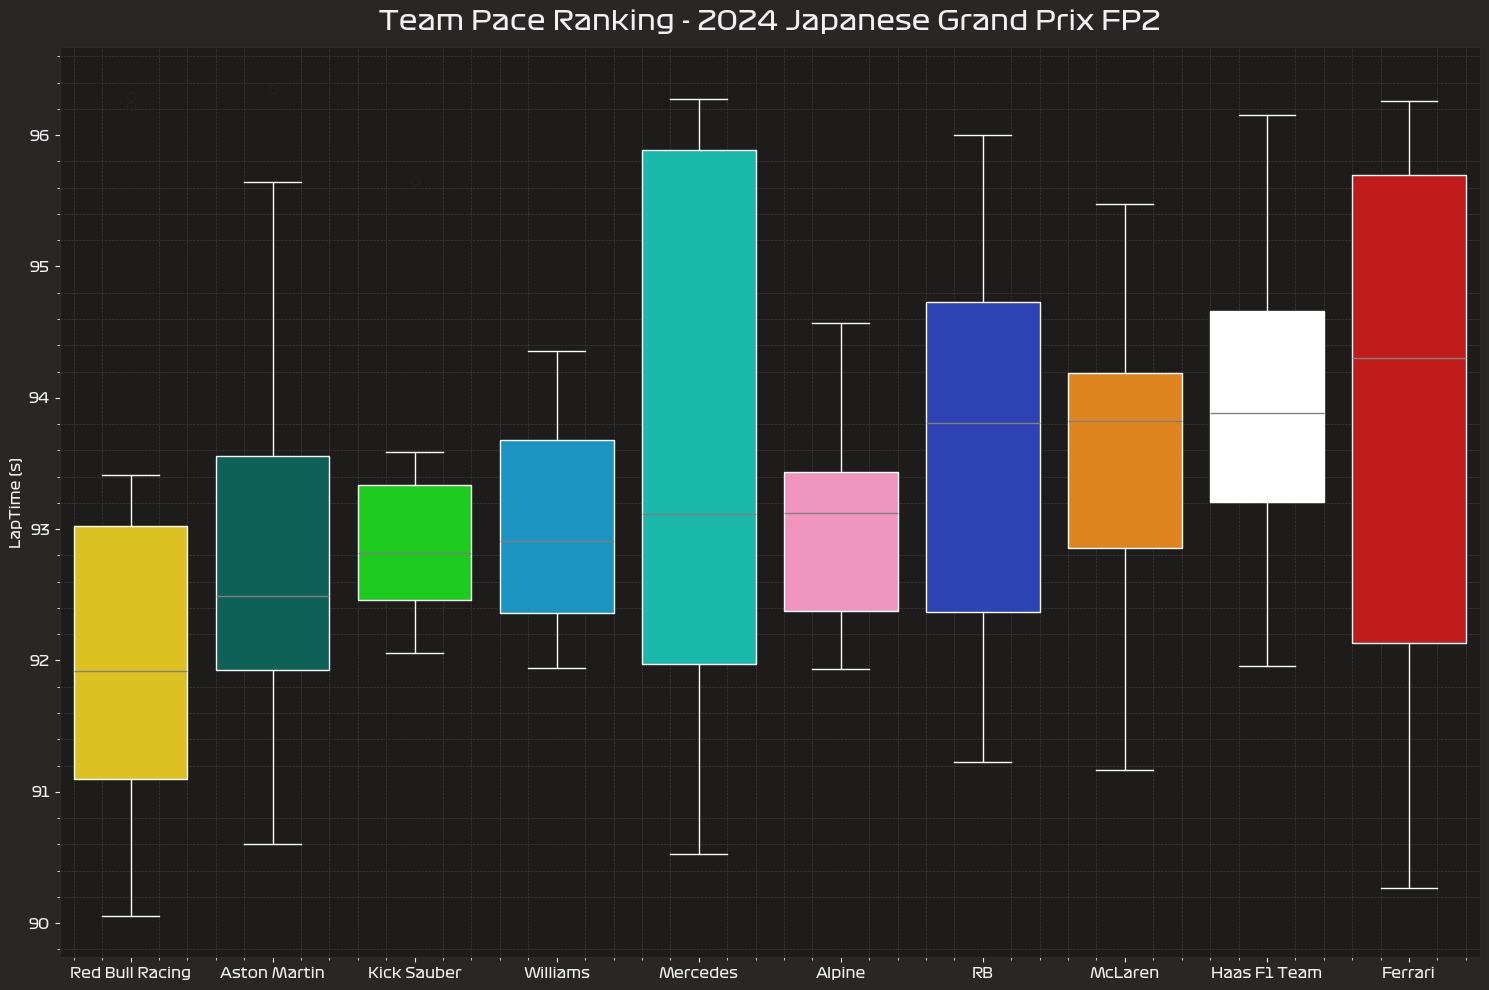

In [36]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(
    data=transformed_laps,
    x="Team",
    y="LapTime (s)",
    hue="Team",
    order=team_order,
    palette=team_palette,
    whiskerprops=dict(color="white"),
    boxprops=dict(edgecolor="white"),
    medianprops=dict(color="grey"),
    capprops=dict(color="white"),
)

plt.title(f"Team Pace Ranking - {grand_prix_year} {grand_prix_name} {grand_prix_session}")
plt.grid(visible=False)

# x-label is redundant
ax.set(xlabel=None)
plt.tight_layout()
plt.show()

Análisis de estrategias de neumatico

In [23]:
def drivers_sorted_by_final_time(laps):
    # Trabajando con una copia para evitar SettingWithCopyWarning
    laps = laps.copy()
    # Calculando el tiempo total en pista para cada piloto
    laps['TotalTime'] = laps.groupby('Driver')['LapTime'].transform('sum')

    # Calculando el número total de vueltas completadas por cada piloto
    laps['TotalLaps'] = laps.groupby('Driver')['LapNumber'].transform('max')

    # Agregando una columna con el último LapStartTime más LapTime como aproximación del tiempo total en pista para quien no completó todas las vueltas
    laps['EndTime'] = laps['LapStartTime'] + laps['LapTime']

    # Obteniendo el tiempo final en pista para cada piloto (útil para aquellos que no completaron la carrera)
    final_times = laps.groupby('Driver')['EndTime'].max()

    # Creando un DataFrame con el resumen de los resultados
    driver_results = pd.DataFrame({
        'TotalLaps': laps.groupby('Driver')['TotalLaps'].first(),
        'TotalTime': laps.groupby('Driver')['TotalTime'].first(),
        'FinalTime': final_times
    }).reset_index()

    # Ordenando los pilotos primero por TotalLaps (descendente) y luego por FinalTime (ascendente)
    driver_results_sorted = driver_results.sort_values(by=['TotalLaps', 'FinalTime'], ascending=[False, True])

    return driver_results_sorted


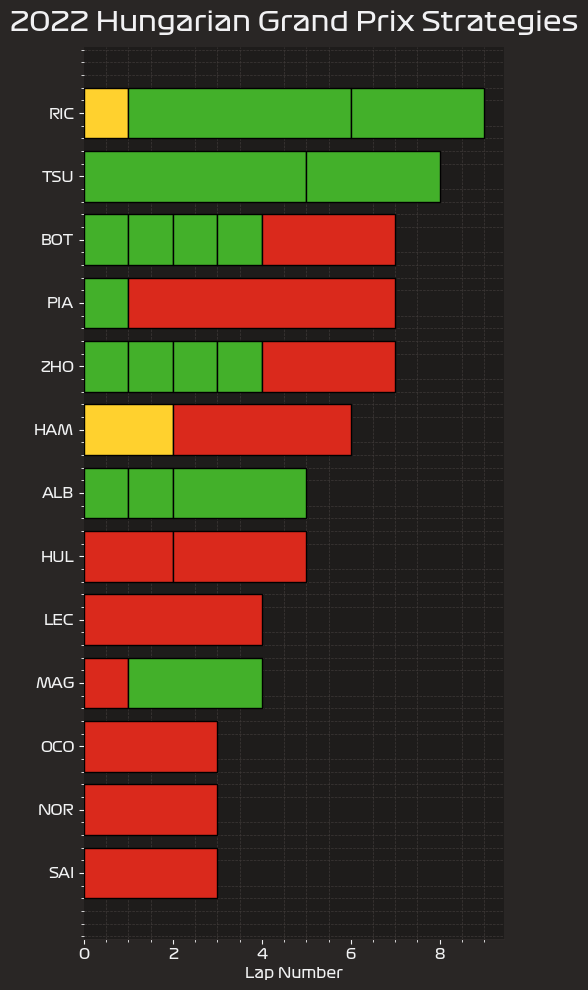

In [37]:
laps = session.laps
#drivers = session.drivers
drivers = drivers_sorted_by_final_time(laps)['Driver']
drivers = [session.get_driver(driver)["Abbreviation"] for driver in drivers]
stints = laps[["Driver", "Stint", "Compound", "LapNumber"]]

stints = stints.groupby(["Driver", "Stint", "Compound"])
stints = stints.count().reset_index()
stints = stints.rename(columns={"LapNumber": "StintLength"})

for drv in session.drivers:
    drv_laps = session.laps.pick_driver(drv)

fig, ax = plt.subplots(figsize=(5, 10))

for driver in drivers:
    driver_stints = stints.loc[stints["Driver"] == driver]

    previous_stint_end = 0
    for idx, row in driver_stints.iterrows():
        # each row contains the compound name and stint length
        # we can use these information to draw horizontal bars
        plt.barh(
            y=driver,
            width=row["StintLength"],
            left=previous_stint_end,
            color=fastf1.plotting.COMPOUND_COLORS[row["Compound"]],
            edgecolor="black",
            fill=True
        )

        previous_stint_end += row["StintLength"]


plt.title("2022 Hungarian Grand Prix Strategies")
plt.xlabel("Lap Number")
plt.grid(False)
# invert the y-axis so drivers that finish higher are closer to the top
ax.invert_yaxis()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

Gráfica de tiempos por vuelta y neumatico

In [15]:
def normalize_to_range(values, new_min=0, new_max=5, adjust=50):
    # Restar 50 a todos los valores antes de la normalización
    adjusted_values = values - adjust
    
    old_min = np.min(adjusted_values)
    old_max = np.max(adjusted_values)
    # Aplicar la fórmula de normalización a los valores ajustados
    scaled_values = new_min + ((adjusted_values - old_min) * (new_max - new_min) / (old_max - old_min))
    return scaled_values


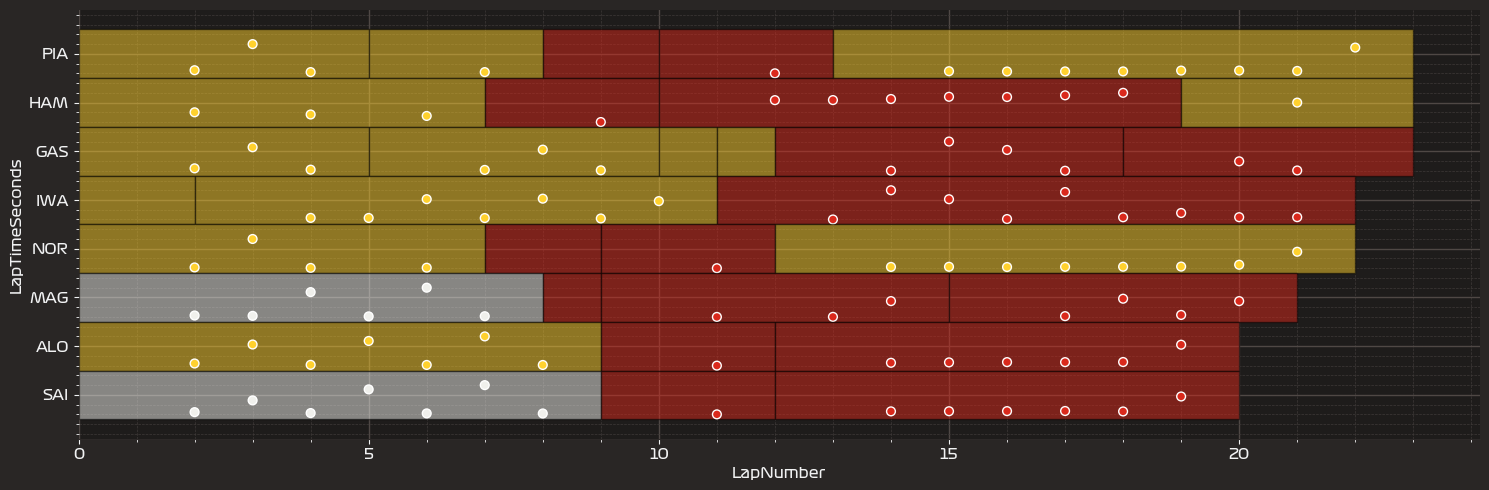

In [25]:

laps = session.laps
#drivers = session.drivers
#drivers = [session.get_driver(driver)["Abbreviation"] for driver in drivers][1:4]
drivers = drivers_sorted_by_final_time(laps)['Driver'][:8]
stints = laps[["Driver", "Stint", "Compound", "LapNumber"]]
#print(stints)
stints = stints.groupby(["Driver", "Stint", "Compound"])
stints = stints.count().reset_index()
stints = stints.rename(columns={"LapNumber": "StintLength"})


fig, ax = plt.subplots(figsize=(15, 5))

# Variables para controlar el layout de las barras
bar_height = 1
current_bottom = 0

###fig, ax = plt.subplots(figsize=(5, 10))

compound_opacity = {
    'soft': 0.6,
    'medium': 0.7,
    'hard': 0.8
    # Añade más compuestos y opacidades según sea necesario
}

for driver in drivers:
    driver_stints = stints.loc[stints['Driver'] == driver]
    driver_laps = laps[laps['Driver'] == driver]
    
    previous_stint_end = 0
    for _, row in driver_stints.iterrows():
        opacity = compound_opacity.get(row['Compound'], 0.5)  # Valor por defecto si el compuesto no está en el diccionario
        
        # Dibujar barra para el stint
        ax.barh(
            y=current_bottom,
            width=row['StintLength'],
            left=previous_stint_end,
            color=fastf1.plotting.COMPOUND_COLORS.get(row['Compound'], 'grey'),
            edgecolor='black',
            height=bar_height,
            alpha=opacity
        )
        previous_stint_end += row['StintLength']
    
    # Dibujar puntos para los tiempos por vuelta
    #driver_laps['LapTimeSeconds'] = driver_laps['LapTime'].dt.total_seconds()
    driver_laps = driver_laps.copy()
    #print(driver_laps['PitInTime'][6])

    driver_laps['LapTimeSeconds'] = driver_laps['LapTime'].dt.total_seconds()

    # Luego, establecemos 'LapTimeSeconds' como NaN para las vueltas en las que el piloto estuvo en el pitstop
    # Esto se hace verificando si 'PitInTime' o 'PitOutTime' tienen algún valor (no son nulos)
    driver_laps.loc[(driver_laps['PitInTime'].notna()) | (driver_laps['PitOutTime'].notna()), 'LapTimeSeconds'] = np.nan


    #print(driver_laps['LapTimeSeconds'])
    #print(pd.Categorical(driver_laps['Driver']).codes + current_bottom + bar_height / 2 + normalize_to_range(driver_laps['LapTimeSeconds']))
    sns.scatterplot(
        data=driver_laps,
        x='LapNumber',
        y=pd.Categorical(driver_laps['Driver']).codes + current_bottom + normalize_to_range(driver_laps['LapTimeSeconds'],0.4,-0.2,90),  # Ajustar y para alinear con la barra del piloto
        hue='Compound',
        palette=fastf1.plotting.COMPOUND_COLORS,
        s=40,
        linewidth=1,
        legend=False,  # Cambiar a 'brief' o 'full' si quieres una leyenda
        ax=ax
    )
    
    current_bottom += 1  # Ajustar para la siguiente barra

ax.set_yticks(range(len(drivers)))
ax.set_yticklabels(drivers)
ax.invert_yaxis()  # Opcional, dependiendo de cómo quieras visualizar los pilotos

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

Ficha grande

In [17]:
" Add team logo "
#import matplotlib.pyplot as plt
#from matplotlib.offsetbox import OffsetImage, AnnotationBbox
#from PIL import Image
#import numpy as np

def add_team_logo(ax, team_name, zoom=0.2, position=(0.5, 0.5)):
    """
    Carga y muestra el escudo del equipo en el eje proporcionado.
    
    Parámetros:
    ax -- el eje de Matplotlib donde se colocará la imagen.
    team_name -- el nombre del equipo, que corresponde al nombre del archivo de imagen.
    zoom -- el nivel de zoom para la imagen.
    """
    base_path = './images/teams/'  # Actualiza con la ruta correcta a tus imágenes
    file_path = f'{base_path}{team_name}.png'  # Asume que el nombre de la imagen es el mismo que el nombre del equipo
    
    try:
        # Carga la imagen
        img = Image.open(file_path)
        
        # Convierte la imagen PIL a un objeto de imagen que Matplotlib pueda manejar
        img = np.array(img)
        
        # Crear el objeto OffsetImage
        imagebox = OffsetImage(img, zoom=zoom)
        
        # Crear el objeto AnnotationBbox y colocarlo en el eje
        ab = AnnotationBbox(imagebox, position, frameon=False, boxcoords="axes fraction")
        ax.add_artist(ab)
        
    except FileNotFoundError:
        print(f'El archivo {file_path} no existe.')



Mapa de sectores


Mejor Sector 1: 0 days 00:00:31.695000
Mejor Sector 2: 0 days 00:00:40.847000
Mejor Sector 3: 0 days 00:00:18.057000
Mejor Sector 1 G: 0 days 00:00:31.603000 VER
Mejor Sector 2 G: 0 days 00:00:40.602000 PER
Mejor Sector 3 G: 0 days 00:00:17.836000 VER


core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


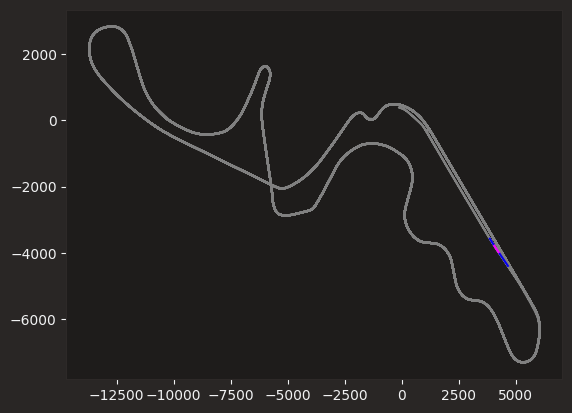

In [18]:
import fastf1 as ff1
from fastf1 import plotting
import matplotlib.pyplot as plt

# Configuración para que las gráficas se vean más estilizadas
plotting.setup_mpl()

# Supongamos que tenemos dos pilotos de interés: VER (Verstappen) y HAM (Hamilton)
piloto1_code = 'ALO'
piloto2_code = 'HAM'

# Obtener las vueltas más rápidas para los pilotos de interés
vuelta_piloto1 = laps.pick_driver(piloto1_code)
# Encuentra el mejor tiempo para cada sector
mejor_sector1 = vuelta_piloto1['Sector1Time'].min()
mejor_sector2 = vuelta_piloto1['Sector2Time'].min()
mejor_sector3 = vuelta_piloto1['Sector3Time'].min()

print(f"Mejor Sector 1: {mejor_sector1}")
print(f"Mejor Sector 2: {mejor_sector2}")
print(f"Mejor Sector 3: {mejor_sector3}")

#vuelta_piloto1 = laps.pick_driver(piloto1_code).pick_fastest()
vuelta_piloto1 = laps.pick_driver(piloto1_code)

# Encuentra el mejor tiempo para cada sector
idx_mejor_sector1 = session.laps['Sector1Time'].idxmin()
idx_mejor_sector2 = session.laps['Sector2Time'].idxmin()
idx_mejor_sector3 = session.laps['Sector3Time'].idxmin()

piloto_mejor_sector1 = session.laps.loc[idx_mejor_sector1, 'Driver']
piloto_mejor_sector2 = session.laps.loc[idx_mejor_sector2, 'Driver']
piloto_mejor_sector3 = session.laps.loc[idx_mejor_sector3, 'Driver']

mejor_sector1_global = session.laps.loc[idx_mejor_sector1, 'Sector1Time']
mejor_sector2_global = session.laps.loc[idx_mejor_sector2, 'Sector2Time']
mejor_sector3_global = session.laps.loc[idx_mejor_sector3, 'Sector3Time']

print(f"Mejor Sector 1 G: {mejor_sector1_global} {piloto_mejor_sector1}")
print(f"Mejor Sector 2 G: {mejor_sector2_global} {piloto_mejor_sector2}")
print(f"Mejor Sector 3 G: {mejor_sector3_global} {piloto_mejor_sector3}")


# Graficar el mapa del circuito
plt.plot(vuelta_piloto1.telemetry['X'], vuelta_piloto1.telemetry['Y'], color='grey')

# Asumiendo que tienes acceso a los índices de los sectores (esto es un supuesto simplificado)
# En la práctica, necesitarías datos reales sobre los límites de cada sector en el circuito
sector1_indices = slice(0, 10)  # Suposición simplificada de los índices para el sector 1
sector2_indices = slice(10, 20) # Suposición para el sector 2
sector3_indices = slice(20, 30) # Suposición para el sector 3


# Resaltar los sectores más rápidos con los colores de los pilotos
plt.plot(vuelta_piloto1.telemetry['X'][sector1_indices], vuelta_piloto1.telemetry['Y'][sector1_indices], color=name_to_color_hex(piloto_mejor_sector1))
plt.plot(vuelta_piloto1.telemetry['X'][sector2_indices], vuelta_piloto1.telemetry['Y'][sector2_indices], color=name_to_color_hex(piloto_mejor_sector2))
plt.plot(vuelta_piloto1.telemetry['X'][sector3_indices], vuelta_piloto1.telemetry['Y'][sector3_indices], color=name_to_color_hex(piloto_mejor_sector3))

# Mostrar la gráfica
plt.show()


el codigo de github


el codigo de github mejorado


Comparación de mejor vuelta

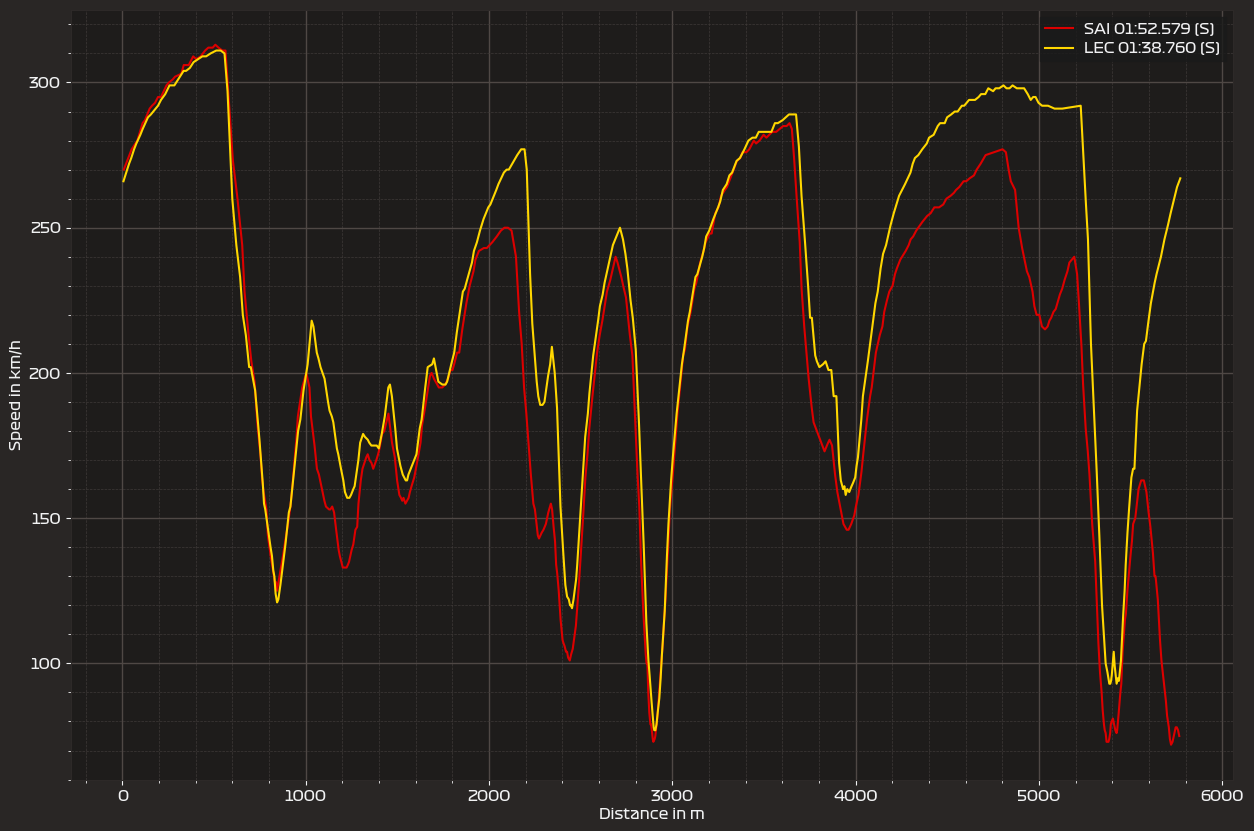

In [38]:
driver_list = ['SAI','LEC']

fig, ax = plt.subplots(figsize=(15, 10))
for driver_code in driver_list:
    # Obtiene la vuelta más rápida para el piloto actual
    driver_lap = session.laps.pick_driver(driver_code).pick_fastest()
    # Obtiene la telemetría para la vuelta más rápida del piloto actual
    driver_telemetry = driver_lap.get_car_data().add_distance()
    # Dibuja la telemetría en la gráfica
    ax.plot(driver_telemetry['Distance'], driver_telemetry['Speed'], 
            color=name_to_color_hex(driver_code), 
            label=f"{driver_code} {format_lap_time(driver_lap['LapTime'])} ({driver_lap['Compound'][0]})")

ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed in km/h')

ax.legend()
#plt.suptitle(f"Fastest Lap Comparison \n "
#             f"{grand_prix_name} {session.event.year} {grand_prix_session}")

# Guarda la figura
# Asegúrate de que el directorio exista
dir_path = f"images/generated/{grand_prix_year}/{grand_prix_weekend}/{driver_list[0]}vs{driver_list[1]}"
os.makedirs(dir_path, exist_ok=True)
plt.savefig(f"{dir_path}/circuit_sectors.png")

plt.show()

Circuito con sus sectores

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


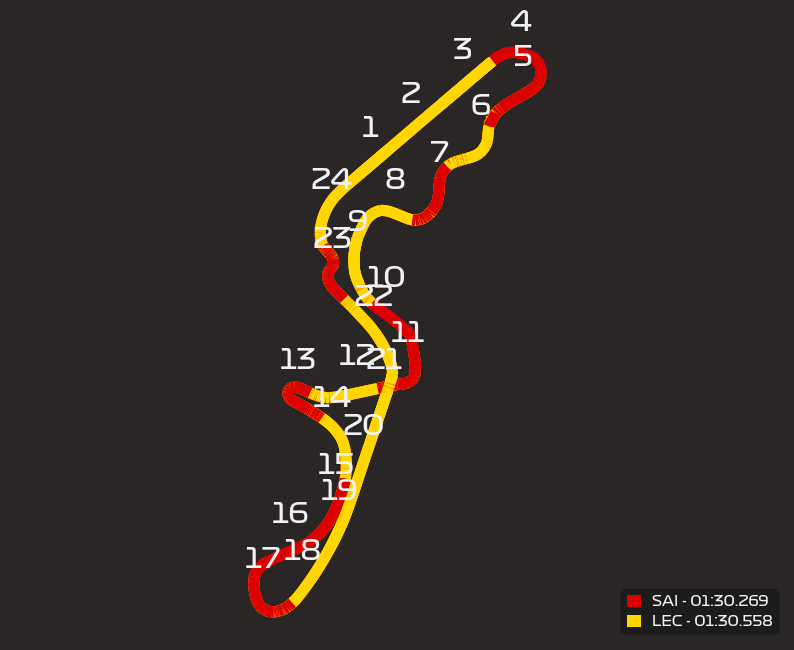

In [26]:
#driver_list = ['VER', 'SAI', 'PER', 'LEC', 'RUS', 'ALO', 'PIA', 'HAM', 'STR']
driver_list = ['SAI','LEC']
# Suponiendo que 'session', 'laps', 'driver_list', y 'driver_colors' están previamente definidos

laps = session.laps
laps = laps.pick_quicklaps(threshold=1.03)

telemetry = pd.DataFrame()
for driver in driver_list:
    driver_telemetry = laps.pick_driver(driver).pick_fastest().get_telemetry().add_distance()
    driver_telemetry['Driver'] = driver
    driver_telemetry['Colour'] = name_to_color_hex(driver)
    driver_number = laps.pick_driver(driver).iloc[0]['DriverNumber']
    driver_telemetry['DriverNumber'] = int(driver_number)

    # Intercambia las coordenadas X e Y, y rota la X para mostrar correctamente el circuito
    driver_telemetry_x = driver_telemetry['X']
    driver_telemetry['X'] = driver_telemetry['Y'] * -1
    driver_telemetry['Y'] = driver_telemetry_x

    telemetry = pd.concat([telemetry, driver_telemetry])


telemetry = telemetry[['Distance', 'Speed', 'X', 'Y', 'Driver', 'DriverNumber', 'Colour', 'Time']]

# Proceso para determinar el piloto más rápido en cada sector

# Configura la figura y ejes
fig, ax = plt.subplots(figsize=(10, 8))

# Obtiene las coordenadas del circuito
x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

# Crea una colección de líneas para los segmentos, utilizando los colores de los pilotos más rápidos en cada minisector
segments = []
segment_colors = []
segment_drivers = []

# Define el número de minisectores
num_minisectors = 24
total_distance = telemetry['Distance'].max()
minisector_length = total_distance / num_minisectors

# Assign distances to each minisector
minisectors = [0]
for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))

# Assign minisector to every row in the telemetry data
telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda z: (
        minisectors.index(
            min(minisectors, key=lambda x: abs(x-z)))+1
    )
)

# Calculate fastest driver (highest average speed) per mini sector
average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()


# Select the driver with the highest average speed
fastest_drivers = average_speed.loc[average_speed.groupby(['Minisector', 'Driver'])['Speed'].idxmax()]

# Assign colors to the fastest drivers in each minisector
minisector_fastest_drivers = fastest_drivers['Driver'].tolist()

minisector_colours = [name_to_color_hex(laps.pick_driver(driver).pick_fastest()['Driver']) for driver in minisector_fastest_drivers]

datos_para_exportar = pd.DataFrame(telemetry)
ruta_archivo = 'telemtry_sectors.csv'
datos_para_exportar.to_csv(ruta_archivo, index=False)
# Create the segments and assign the colors
minisector_driver_champion = []
for i in range(len(x)-1):
    segments.append([(x[i], y[i]), (x[i+1], y[i+1])])
    segment_colors.append(minisector_colours[telemetry['Minisector'].iloc[i] - 1])
    segment_drivers.append(minisector_fastest_drivers[telemetry['Minisector'].iloc[i] - 1])
    
# Función para convertir la columna 'Time' a segundos
def convert_to_seconds(timedelta_str):
    match = re.match(r'(?P<days>\d+) days (?P<hours>\d{2}):(?P<minutes>\d{2}):(?P<seconds>\d{2}).(?P<microseconds>\d+)', timedelta_str)
    if not match:
        return None
    time_data = match.groupdict()
    time_delta = timedelta(days=int(time_data['days']),
                           hours=int(time_data['hours']),
                           minutes=int(time_data['minutes']),
                           seconds=int(time_data['seconds']),
                           microseconds=int(time_data['microseconds']))
    return time_delta.total_seconds()

driver_for_sector = [] # Inicializa un array vacío
# Muestra la velocidad media del sector
for i in range(1, num_minisectors + 1):

    # Filtra la telemetría por minisector
    minisector_data = telemetry[telemetry['Minisector'] == i]

    datos_para_exportar = pd.DataFrame(minisector_data)
    ruta_archivo = f"minisector_{i}_data.csv"
    datos_para_exportar.to_csv(ruta_archivo, index=False)

    df = pd.DataFrame()
    if not minisector_data.empty:

        # Asumiendo que 'df' es tu DataFrame
        # Convierte la columna 'Time' a segundos
        #df['TimeInSeconds'] = df['Time'].apply(convert_to_seconds)

        # Encuentra el tiempo mínimo y máximo por piloto y minisector
        min_times = datos_para_exportar.groupby(['Driver', 'Minisector'])['Time'].min().reset_index(name='MinTime')
        max_times = datos_para_exportar.groupby(['Driver', 'Minisector'])['Time'].max().reset_index(name='MaxTime')

        # Fusiona los mínimos y máximos en un solo DataFrame
        times = pd.merge(min_times, max_times, on=['Driver', 'Minisector'])

        # Calcula la diferencia de tiempo para cada piloto en cada minisector
        times['TimeDiff'] = times['MaxTime'] - times['MinTime']

        # Ordena y encuentra el piloto más rápido por minisector
        fastest_pilots = times.loc[times.groupby('Minisector')['TimeDiff'].idxmin()]

        # Muestra el resultado

        # Calcula la posición media del minisector
        avg_x = minisector_data['X'].mean()
        avg_y = minisector_data['Y'].mean()
        
        # Obtiene la velocidad promedio para el minisector
        avg_speed = minisector_data['Speed'].mean()
        
        # Velocidad media de sector
        #plt.annotate(f'{avg_speed:.2f} km/h', (avg_x, avg_y), textcoords="offset points", xytext=(0,0), ha='center')

        min_time = minisector_data['Time'].min()
        max_time = minisector_data['Time'].max()
        sector_time = max_time - min_time

        # Tiempo del sector
        #plt.annotate(f'{format_lap_time(sector_time)}', (avg_x, avg_y), textcoords="offset points", xytext=(0,0), ha='center')
        sector_time_fastest = format_lap_time(fastest_pilots['TimeDiff'].iloc[0])
        #plt.annotate(f'{sector_time_fastest}', (avg_x, avg_y), textcoords="offset points", xytext=(0,-10), ha='center')

        # Piloto
        driver_name_fastest = fastest_pilots['Driver'].iloc[0]
        #plt.annotate(f'{driver_name_fastest}', (avg_x, avg_y), textcoords="offset points", xytext=(0,10), ha='center')
        driver_for_sector.append(driver_name_fastest)

        # Número del sector
        plt.annotate(f'{i}', (avg_x, avg_y), textcoords="offset points", fontsize= 20, xytext=(0,20), ha='center')

for i in range(len(x)-1):
    segments.append([(x[i], y[i]), (x[i+1], y[i+1])])
    segment_colors.append(name_to_color_hex(driver_for_sector[telemetry['Minisector'].iloc[i] - 1]))

# Crea una colección de líneas para los segmentos usando los colores asignados
lc = LineCollection(segments, colors=segment_colors, linewidths=8)

# Añade la colección de líneas al plot
ax.add_collection(lc)
ax.autoscale()
#ax.margins(0.1)
plt.axis('equal')
plt.axis('off')
from matplotlib.patches import Patch
# Crear una lista de elementos de leyenda manualmente
#legend_elements = [Patch(facecolor=name_to_color_hex(driver), edgecolor='none', label='VER'),
#                   Patch(facecolor=name_to_color_hex('SAI'), edgecolor='none', label='SAI')]
legend_elements = [Patch(facecolor=name_to_color_hex(driver_list[i]), edgecolor='none', label=f"{driver_list[i]} - {format_lap_time(laps.pick_driver(driver_list[i]).pick_fastest()['LapTime'])}") 
                   for i in range(len(driver_list))]

# Añadir la leyenda con los elementos personalizados
#plt.legend(handles=legend_elements, handlelength=1, handleheight=1, loc='lower right')


# Guarda la figura
# Asegúrate de que el directorio exista
dir_path = f"images/generated/{grand_prix_year}/{grand_prix_weekend}/{driver_list[0]}vs{driver_list[1]}"
os.makedirs(dir_path, exist_ok=True)
plt.savefig(f"{dir_path}/circuit_sectors.png")


plt.legend(handles=legend_elements, handlelength=1, handleheight=1, loc='lower right')
# Muestra el plot
plt.show()



In [28]:
def dibujar_barras(ax, titles, data_analysis, gear_time_percentage=gear_time_percentage, fontsize_percentage=10, formula1_font_bold=None):
    print(data_analysis.columns)
    posicion_inicial_y = 0.2  # Empezamos desde el tope y bajamos
    small_gap = 0.05  # Asumiendo un valor para small_gap
    large_gap = 0.1  # Asumiendo un valor para large_gap
    bar_height = 0.15  # Asumiendo un valor para bar_height
    print(data_analysis.iloc(0))
    for title, porcentaje in zip(titles, porcentajes):
        # Dibujar el título
        ax.text(0, posicion_inicial_y, title, ha='left', va='bottom', fontsize=13.5, color='grey')
        # Ajustar la posición para la barra, considerando el espacio pequeño
        posicion_barra = posicion_inicial_y - small_gap - bar_height
        # Dibujar la barra de fondo
        ax.barh(posicion_barra, 100, height=bar_height, color='grey')
        if titulo == 'Gear Number' and gear_time_percentage is not None:
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
            start_pos = 0
            for gear, percentage in gear_time_percentage.items():
                color = colors[gear % len(colors)]
                ax.barh(posicion_barra, percentage, left=start_pos, color=color, height=bar_height)
                mid_point = start_pos + (percentage / 2)
                text_label = f'{gear}\n({percentage:.1f}%)'
                ax.text(mid_point, posicion_barra - 0.35, text_label, ha='center', va='top', color='white', fontsize=9)
                start_pos += percentage
        else:
            ax.barh(posicion_barra, porcentaje, height=bar_height, color=color_barra)
            ax.text(+ 100 + 2, posicion_barra, f'{porcentaje}%', va='center', ha='left', color='white', fontsize=fontsize_percentage, fontproperties=formula1_font_bold)
        # Ajustar la posición inicial para el siguiente grupo, considerando el espacio grande
        posicion_inicial_y = posicion_barra - large_gap

    ax.text(-0.02, 0.55, '% LAP TIME',
            horizontalalignment='right',
            verticalalignment='center',
            rotation='vertical',
            color='grey',
            fontsize=15,
            transform=ax.transAxes)

# Ejemplo de uso
# dibujar_barras(ax7, titulos, porcentajes, gear_time_percentage=gear_time_percentage, color_barra='blue', desplazamiento_x=0, fontsize_percentage=10, formula1_font_bold=None)


NameError: name 'gear_time_percentage' is not defined

Ficha completa

DriverNumber                                                         16
BroadcastName                                                 C LECLERC
Abbreviation                                                        LEC
DriverId                                                               
TeamName                                                        Ferrari
TeamColor                                                        E80020
TeamId                                                                 
FirstName                                                       Charles
LastName                                                        Leclerc
FullName                                                Charles Leclerc
HeadshotUrl           https://media.formula1.com/d_driver_fallback_i...
CountryCode                                                         MON
Position                                                            NaN
ClassifiedPosition                                              

NameError: name 'porcentaje_completado_frenada' is not defined

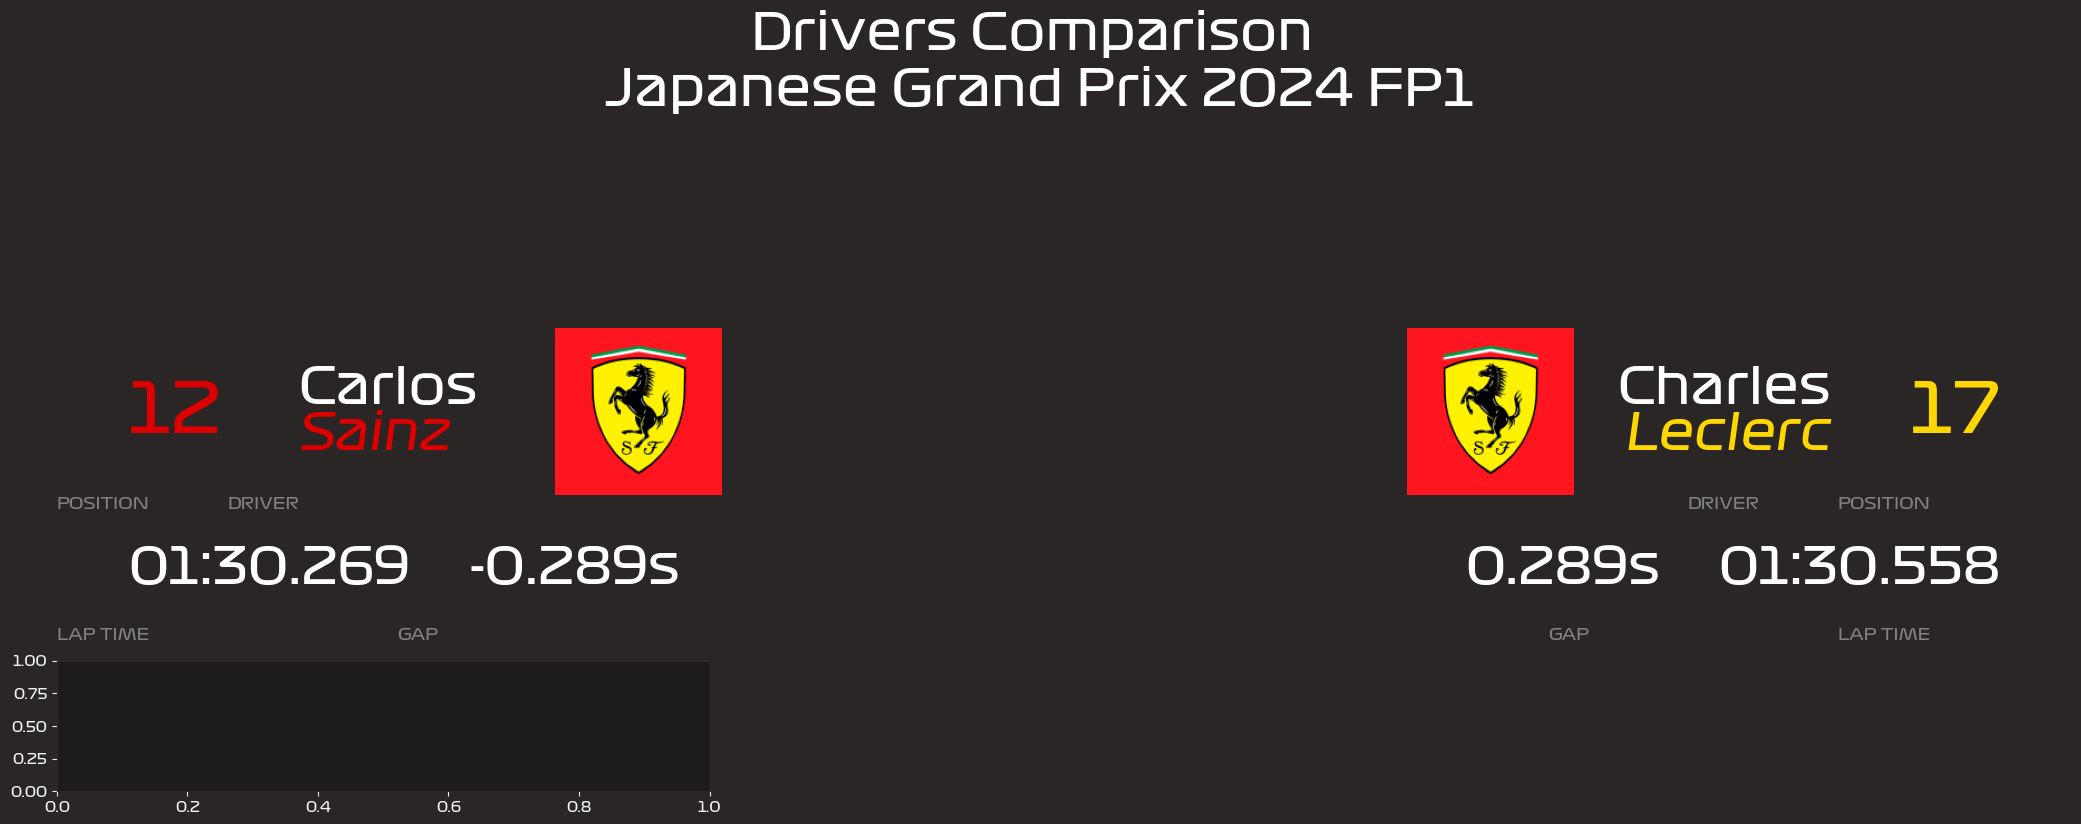

In [29]:
#import numpy as np
#import matplotlib.pyplot as plt
#from matplotlib import gridspec
from matplotlib.image import imread
from matplotlib import font_manager

ruta_fuente_personalizada = 'fonts/Formula1-Regular-1.ttf'
formula1_font = font_manager.FontProperties(fname=ruta_fuente_personalizada, size=15)
# Agregar la fuente al gestor de fuentes de Matplotlib
font_manager.fontManager.addfont(ruta_fuente_personalizada)
# Establecer la fuente personalizada como la predeterminada para todos los textos
plt.rcParams['font.family'] = formula1_font.get_name()
ruta_fuente_personalizada_bold = 'fonts/Formula1-Bold-4.ttf'
formula1_font_bold = font_manager.FontProperties(fname=ruta_fuente_personalizada_bold, size=15)
ruta_fuente_personalizada_italic = 'fonts/Formula1-Italic.ttf'
formula1_font_italic = font_manager.FontProperties(fname=ruta_fuente_personalizada_italic, size=15)


drivers_to_compare = driver_list
drivers_sorted = drivers_sorted_by_final_time(laps)['Driver'].to_list()

driver_1 = session.get_driver(drivers_to_compare[0])
driver_2 = session.get_driver(drivers_to_compare[1])

font_driver_number = 50
font_driver_name = 36

# Datos simulados
n_vueltas = 11
vueltas = np.arange(1, n_vueltas + 1)
tiempos_leclerc = np.random.uniform(80, 90, size=n_vueltas)
tiempos_sainz = tiempos_leclerc + np.random.normal(0, 0.2, size=n_vueltas)  # tiempos similares con variación normal
delta_tiempo = tiempos_sainz - tiempos_leclerc

# Iniciar la figura con GridSpec
fig = plt.figure(figsize=(26, 18))
gs = gridspec.GridSpec(9, 12, figure=fig)

#for row in range(1, 8):
#    plt.axhline(row / 8, color='grey', linestyle='--', linewidth=0.5)

#for col in range(1, 12):
#    plt.axvline(col / 12, color='grey', linestyle='--', linewidth=0.5)

# Título grande del header
fig.suptitle(f"Drivers Comparison\n "
             f"{grand_prix_name} {session.event.year} {grand_prix_session}", fontsize=36, color='white')

driver_1_best_lap = session.laps.pick_driver(drivers_to_compare[0]).pick_fastest()['LapTime']
driver_2_best_lap = session.laps.pick_driver(drivers_to_compare[1]).pick_fastest()['LapTime']
driver_1_gap = driver_1_best_lap.total_seconds() - driver_2_best_lap.total_seconds()
driver_2_gap = driver_2_best_lap.total_seconds() - driver_1_best_lap.total_seconds()

# Información del piloto 1
ax1 = fig.add_subplot(gs[1, 0])
ax1.text(0, -0.2, "POSITION", ha='left', va='center', fontsize=12, color='grey', fontproperties=formula1_font)
ax1.text(0.5, 0.5, f"{drivers_sorted.index(drivers_to_compare[0]) + 1}", ha='left', va='center', fontsize=font_driver_number, color=name_to_color_hex(drivers_to_compare[0]))
ax1.axis('off')

ax2 = fig.add_subplot(gs[1, 1])
ax2.text(0, -0.2, "DRIVER", ha='left', va='center', fontsize=12, color='grey', fontproperties=formula1_font)
ax2.text(0.5, 0.5, f"{driver_1['FirstName']}", ha='left', va='bottom', fontsize=font_driver_name, color='white')
ax2.text(0.5, 0.5, f"{driver_1['LastName']}", ha='left', va='top', fontsize=font_driver_name, color=name_to_color_hex(drivers_to_compare[0]), fontproperties=formula1_font_italic)
ax2.axis('off')

ax3 = fig.add_subplot(gs[1, 3])
add_team_logo(ax3, f"{driver_1['TeamName']}", zoom=0.8)  # reemplaza 'nombre_equipo' con el nombre correspondiente
ax3.axis('off')

ax31 = fig.add_subplot(gs[2, 0])
ax31.text(0, 0, "LAP TIME", ha='left', va='center', fontsize=12, color='grey')
ax31.text(0.5, 0.5, f"{format_lap_time(driver_1_best_lap)}", ha='left', va='center', fontsize=font_driver_name, color='white')
ax31.axis('off')

ax32 = fig.add_subplot(gs[2, 2:3])
ax32.text(0, 0, "GAP", ha='left', va='center', fontsize=12, color='grey')
ax32.text(0.5, 0.5, f"{round(driver_1_gap,3)}s", ha='left', va='center', fontsize=font_driver_name, color='white')
ax32.axis('off')

telemetria = session.laps.pick_driver(drivers_to_compare[0]).pick_fastest().get_telemetry()
full_throttle = telemetria['Throttle'] == 100

# Cálculo de intervalos de tiempo entre puntos de datos para ponderar correctamente el tiempo en cada estado
# Convertir 'SessionTime' o 'Date' a datetime si no lo está ya
telemetria['Date'] = pd.to_datetime(telemetria['Date'])
telemetria['TimeDiff'] = telemetria['Date'].diff().dt.total_seconds().fillna(0)

# Tiempo total en cada estado, ponderado por TimeDiff
total_time_full_throttle = telemetria.loc[full_throttle, 'TimeDiff'].sum()
# Tiempo total de la sesión
total_session_time = telemetria['TimeDiff'].sum()

# Calcula los porcentajes
porcentaje_full_throttle = (total_time_full_throttle / total_session_time) * 100

# Cuenta el número de veces que el piloto está frenando (Brake == True)
frenadas = telemetria['Brake'].sum()

# Número total de puntos de datos
total_data_points = len(telemetria)

# Calcula el porcentaje de frenadas sobre el total de puntos de datos
porcentaje_frenadas = (frenadas / total_data_points) * 100

# Información del piloto 2
ax4 = fig.add_subplot(gs[1, 11])
ax4.text(0, -0.2, "POSITION", ha='right', va='center', fontsize=12, color='grey')
ax4.text(0.5, 0.5, f"{drivers_sorted.index(drivers_to_compare[1]) + 1}", ha='right', va='center', fontsize=font_driver_number, color=name_to_color_hex(drivers_to_compare[1]))
ax4.axis('off')

ax5 = fig.add_subplot(gs[1, 10])
ax5.text(0, -0.2, "DRIVER", ha='right', va='center', fontsize=12, color='grey')
print(driver_2)
ax5.text(0.5, 0.5, f"{driver_2['FirstName']}", ha='right', va='bottom', fontsize=font_driver_name, color='white')
ax5.text(0.5, 0.5, f"{driver_2['LastName']}", ha='right', va='top', fontsize=font_driver_name, color=name_to_color_hex(drivers_to_compare[1]), fontproperties=formula1_font_italic)
ax5.axis('off')

ax6 = fig.add_subplot(gs[1, 8])
add_team_logo(ax6, f"{driver_2['TeamName']}", zoom=0.8)  # reemplaza 'nombre_equipo' con el nombre correspondiente
ax6.axis('off')

ax62 = fig.add_subplot(gs[2, 9])
ax62.text(0, 0, "GAP", ha='right', va='center', fontsize=12, color='grey')
ax62.text(0.5, 0.5, f"{round(driver_2_gap,3)}s", ha='right', va='center', fontsize=font_driver_name, color='white')
ax62.axis('off')

ax61 = fig.add_subplot(gs[2, 11])
ax61.text(0, 0, "LAP TIME", ha='right', va='center', fontsize=12, color='grey')
ax61.text(0.5, 0.5, f"{format_lap_time(driver_2_best_lap)}", ha='right', va='center', fontsize=font_driver_name, color='white')
ax61.axis('off')

# Otros datos para los pilotos
ax7 = fig.add_subplot(gs[3, 0:4])
desplazamiento_x = 0
# Aumentar el espacio entre las barras
espacio_entre_barras = 0.25  # Ajusta este valor para cambiar el espacio entre las barras

#ax7.text(0.5, 0.5, 'Otros Datos\nPiloto 1', ha='center', va='center', fontsize=12, color='white')
porcentaje_completado_full_throttle = round(porcentaje_full_throttle,1)

#### nGEAR
df = pd.DataFrame(telemetria)
df['TimeDelta'] = df['Time'].diff().dt.total_seconds().fillna(0)
gear_time = df.groupby('nGear')['TimeDelta'].sum()
total_time = gear_time.sum()
gear_time_percentage = (gear_time / total_time) * 100

# Colores
color_barra = name_to_color_hex(drivers_to_compare[0])  # Puedes cambiarlo por cualquier color que desees
color_fondo = '#4D4D4D'  # Gris oscuro
fontsize_percentage = 16

# Calcular el desplazamiento vertical para cada barra y su título correspondiente
posicion_inicial_y = 0.5  # Posición vertical de la primera barra
desplazamiento_titulo = 0.35  # Desplazamiento vertical del título respecto a su barra
espacio_grande = 0.6  # Ajusta este valor para cambiar el gran espacio entre grupos de título y barra

# Crear las barras y los títulos
other_data_titles = ['Full Throttle', 'Braking', 'Gear Number']
porcentajes = [porcentaje_completado_full_throttle, porcentaje_completado_frenada, porcentaje_completado_frenada]

# Configuraciones de espacios y altura de barra
bar_height = 0.2
small_gap = 0.02  # Espacio pequeño después de cada título
large_gap = 1.75  # Espacio grande después de cada barra

# Posición inicial para el primer elemento
posicion_inicial_y = 0.2  # Empezamos desde el tope y bajamos

for title, porcentaje in zip(other_data_titles, porcentajes):
    # Dibujar el título
    ax7.text(0, posicion_inicial_y, title, ha='left', va='bottom', fontsize=13.5, color='grey')
    # Ajustar la posición para la barra, considerando el espacio pequeño
    posicion_barra = posicion_inicial_y - small_gap - bar_height
    # Dibujar la barra de fondo
    ax7.barh(posicion_barra, 100, height=bar_height, color='grey')
    # Dibujar la barra de completación
    if (title == 'Gear Number'):
        # Colores para las marchas
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        start_pos = 0
        # Dibujar las secciones de la barra de marchas
        for gear, percentage in gear_time_percentage.items():
            color = colors[gear % len(colors)]  # Elegir color de la lista, usando módulo para ciclar si hay más de 10 marchas
            ax7.barh(posicion_barra, percentage, left=start_pos, color=color, height=bar_height)
            mid_point = start_pos + (percentage / 2)  # Calcular el punto medio para colocar el texto
            text_label = f'{gear}\n({percentage:.1f}%)'  # Formatear etiqueta con número de marcha y porcentaje
            ax7.text(mid_point, posicion_barra - 0.35, text_label, ha='center', va='top', color='white', fontsize=9)
            start_pos += percentage  # Actualizar la posición de inicio para la próxima sección
    else:
        # Dibujar la barra de completación
        ax7.barh(posicion_barra, porcentaje, height=bar_height, color=color_barra)
        ax7.text(desplazamiento_x + 100 + 2, posicion_barra, f'{porcentaje}%', va='center', ha='left', color='white', fontsize=fontsize_percentage, fontproperties=formula1_font_bold)
        # Ajustar la posición inicial para el siguiente grupo, considerando el espacio grande
        posicion_inicial_y = posicion_barra - large_gap

ax7.text(-0.02, 0.55, '% LAP TIME',
        horizontalalignment='right',
        verticalalignment='center',
        rotation='vertical',
        color='grey',
        fontsize=15,
        transform=ax7.transAxes)
#ax7.set_ylim(-0.45, 0.15)  # Asegúrate de que las barras y texto son completamente visibles
ax7.axis('off')

ax8 = fig.add_subplot(gs[3, 8:12])
#ax8.text(0.5, 0.5, 'Otros Datos\nPiloto 2', ha='center', va='center', fontsize=12, color='white')


other_data_results = []

for driver in drivers_to_compare:
    telemetria = session.laps.pick_driver(driver).pick_fastest().get_telemetry()
    full_throttle = telemetria['Throttle'] == 100

    # Convertir 'SessionTime' o 'Date' a datetime si no lo está ya
    telemetria['Date'] = pd.to_datetime(telemetria['Date'])
    telemetria['TimeDiff'] = telemetria['Date'].diff().dt.total_seconds().fillna(0)

    # Tiempo total en full throttle, ponderado por TimeDiff
    total_time_full_throttle = telemetria.loc[full_throttle, 'TimeDiff'].sum()
    # Tiempo total de la sesión
    total_session_time = telemetria['TimeDiff'].sum()
    # Calcula los porcentajes
    porcentaje_full_throttle = (total_time_full_throttle / total_session_time) * 100

    # Cuenta el número de veces que el piloto está frenando (Brake == True)
    frenadas = telemetria['Brake'].sum()
    # Número total de puntos de datos
    total_data_points = len(telemetria)
    # Calcula el porcentaje de frenadas sobre el total de puntos de datos
    porcentaje_frenadas = (frenadas / total_data_points) * 100

    # Añadir los resultados a una lista para su posterior uso o análisis
    other_data_results.append({
        'Driver': driver,
        'Throttle': porcentaje_full_throttle,
        'Braking': porcentaje_frenadas,
        'TimeThrottle': total_time_full_throttle,
        'SessionTime': total_session_time,
        'TotalBraking': frenadas,
        'DataPoints': total_data_points
    })

# Convertir resultados a DataFrame para un análisis más fácil
other_data_analysis = pd.DataFrame(other_data_results)
#dibujar_barras(ax8, other_data_titles, other_data_analysis, gear_time_percentage=gear_time_percentage, fontsize_percentage=10, formula1_font_bold=None)
ax8.invert_xaxis()  # Invertir el eje X

ax8.axis('off')

# Mapa del circuito en el centro
mapa_circuito_imagen = imread(f'images/generated/{grand_prix_year}/{grand_prix_weekend}/{driver_list[0]}vs{driver_list[1]}/circuit_sectors.png')
ax_map = fig.add_subplot(gs[0:4, 4:8])
#ax_map.text(0.5, 0.5, 'Mapa\ndel Circuito', ha='center', va='center', fontsize=12, color='white')
h, w, _ = mapa_circuito_imagen.shape
recorte_vertical = int(0.1 * h)
recorte_horizontal = int(0.1 * w)
mapa_recortado = mapa_circuito_imagen[recorte_vertical:-recorte_vertical, recorte_horizontal:-recorte_horizontal]
ax_map.imshow(mapa_recortado)  # Mostramos la imagen precalculada aquí
ax_map.margins(0.5)
ax_map.axis('off')


# Tiempos por vuelta de ambos pilotos
ax_time_comparison = fig.add_subplot(gs[4:7, :])
ax_time_comparison.set_title('Best personal lap')
ax_time_comparison.set_xlabel('Distance')
ax_time_comparison.set_ylabel('Speed (km/h)')

for driver_code in driver_list:
    # Obtiene la vuelta más rápida para el piloto actual
    driver_lap = session.laps.pick_driver(driver_code).pick_fastest()
    # Obtiene la telemetría para la vuelta más rápida del piloto actual
    driver_telemetry = driver_lap.get_car_data().add_distance()
    # Dibuja la telemetría en la gráfica
    ax_time_comparison.plot(driver_telemetry['Distance'], driver_telemetry['Speed'], 
            color=name_to_color_hex(driver_code), 
            label=f"{driver_code} {format_lap_time(driver_lap['LapTime'])} ({driver_lap['Compound'][0]})")
ax_time_comparison.legend()

# Delta de tiempo entre ellos en la fila 8
#ax_delta_time = fig.add_subplot(gs[7, :])
#ax_delta_time.bar(vueltas, delta_tiempo, color='cyan')
ax_race_position = fig.add_subplot(gs[7:9, 0:5])
for drv in driver_list:
    drv_laps = session.laps.pick_driver(drv)

    abb = drv_laps['Driver'].iloc[0]
    color = fastf1.plotting.driver_color(abb)

    ax_race_position.plot(drv_laps['LapNumber'], drv_laps['Position'],
            label=abb, color=name_to_color_hex(drv))
    
ax_race_position.set_ylim([20.5, 0.5])
ax_race_position.set_yticks([1, 5, 10, 15, 20])
ax_race_position.set_xlabel('Lap')
ax_race_position.set_ylabel('Position')
ax_race_position.set_title('Race position')

## ESTRATEGIA DE CARRERA
ax_race_strategy = fig.add_subplot(gs[7:9, 5:8])
stints = laps[["Driver", "Stint", "Compound", "LapNumber"]]
stints = stints.groupby(["Driver", "Stint", "Compound"])
stints = stints.count().reset_index()
stints = stints.rename(columns={"LapNumber": "StintLength"})
for driver in drivers_to_compare:
    driver_stints = stints.loc[stints["Driver"] == driver]
    print(driver_stints)
    previous_stint_end = 0
    for idx, row in driver_stints.iterrows():
        # each row contains the compound name and stint length
        # we can use these information to draw horizontal bars
        ax_race_strategy.barh(
            y=driver,
            width=row["StintLength"],
            left=previous_stint_end,
            color=fastf1.plotting.COMPOUND_COLORS[row["Compound"]],
            edgecolor="black",
            fill=True
        )

        previous_stint_end += row["StintLength"]
ax_race_strategy.set_title('Tyre strategy')
ax_race_strategy.spines['top'].set_visible(False)
ax_race_strategy.spines['right'].set_visible(False)
ax_race_strategy.spines['left'].set_visible(False)

## Race laps
ax_race_laps = fig.add_subplot(gs[7:9, 8:12])
for driver in drivers_to_compare:
    # Obtenemos las vueltas rápidas del piloto y reseteamos el índice para evitar problemas de alineación de datos.
    driver_laps = session.laps.pick_driver(driver).pick_quicklaps().reset_index()

    # Utilizamos seaborn para graficar, asegurando que cada piloto tenga un color único asignado por 'name_to_color_hex'.
    sns.scatterplot(data=driver_laps,
                    x="LapNumber",  # Número de vuelta
                    y="LapTime",    # Tiempo de vuelta
                    ax=ax_race_laps,  # Asegúrate de que este es el nombre correcto de tu objeto Axes
                    color=name_to_color_hex(driver),  # Asignación de color único por piloto
                    s=20,  # Tamaño del punto
                    linewidth=0)  # Sin borde alrededor del punto

# Configuración de los labels de los ejes después de crear todos los scatter plots, para evitar sobreescrituras.
ax_race_laps.set_xlabel("Lap Number")
ax_race_laps.set_ylabel("Lap Time")
ax_race_laps.invert_yaxis()
ax_race_laps.set_title('Laptimes Scatterplot')
sns.despine(left=True, bottom=True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajusta el layout para el título
plt.show()
